# Neural Network Surface Calibration - Layer Test

Scope of the following code is first to perform a NN approximation of a surface dataset, and hence use the approximation to calibrate model parameters.

The code is structured so that it is only needed to specify the correct model name in order to make it work properly. Nevertheless, for representation purposes, there are few details that are model-specific.

## Utility functions

In the following cells few auxiliary functions.

#### Preprocessing

Functions for data preprocessing.

In [1]:
def myscale(x,ub,lb):
    res = np.zeros (len(ub))
    for i in range (len(ub)):
        res[i] = (x[i] - (ub[i] + lb[i]) * 0.5) * 2 / (ub[i] - lb[i])

    return res


def myinverse(x,ub,lb):
    res = np.zeros (len(ub))
    for i in range (len(ub)):
        res[i] = x[i] * (ub[i] - lb[i]) * 0.5 + (ub[i] + lb[i]) * 0.5

    return res

In [2]:
def xtransform(X_train, X_test):
    return [scale2.transform (X_train), scale2.transform (X_test)]


def xinversetransform(x):
    return scale2.inverse_transform (x)

import keras.backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

## Settings

Initial setting of variables of interest and model specification. Also, loading the dataset and performing some pre-processing.

In [3]:
import gzip
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import scipy

model_name = ["rBergomi","Bergomi1Factor","Heston","VGSSD","NIGSSD","rBergomiTermStructure","1FactorTermStructure"]
num_params = [4,4,5,4,4,11,11]

strikes = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5])
maturities = np.array([0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.0])

S0=1.
strikes_dim=len(strikes)
maturities_dim=len(maturities)

## Model approximation

Approximation of the mapping between parameters and volatility surface:
$$\theta^{params} \mapsto Vol_{surface}$$

The function is implemented to be completely working as it is, for this reason there will be a second round of data loading and pre-processing. The code is actually fully run only if no pre-existing model weight are found. This in order to avoid usless and costly code running.

In [4]:
def GeneralizedNNCalibration3L(model_name,n_parameters,strikes,maturities,random_state=42,plot_history=False,verbose=-1):
    
    f = gzip.GzipFile('Dataset/' + model_name + 'TrainSet.txt.gz', "r")
    dat = np.load(f)
    f.close()
    xx = dat[:, :n_parameters]
    yy = dat[:, n_parameters:]
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(yy, xx, test_size=0.15, random_state=42)

    ub = np.max(xx,axis=0)
    lb = np.min(xx,axis=0)
    
    scale2=StandardScaler()
    
    scale2.fit(X_train)

    [x_train_transform, x_test_transform] = [scale2.transform (X_train), scale2.transform (X_test)]

    y_train_transform = np.array([myscale(y,ub,lb) for y in y_train])
    y_test_transform = np.array([myscale(y,ub,lb) for y in y_test])
    
    # %% Construct the NN
    
    from keras.layers import Dense
    from keras.models import Sequential
    from keras.callbacks import EarlyStopping

    #'''
    model = Sequential()

    model.add(Dense(32,activation = 'elu',input_shape=(n_parameters,)))
    model.add(Dense(32,activation = 'elu'))
    model.add(Dense(32,activation = 'elu'))

    model.add(Dense(88,activation = 'linear'))

    model.compile(loss = root_mean_squared_error, optimizer = "adam")

    earlystop = EarlyStopping(monitor='val_loss', mode='min', patience=150, restore_best_weights=True)

    #start = time.time()
    model_history = model.fit(y_train_transform, x_train_transform, batch_size=128,\
                    validation_split = 0.1,epochs = 1000, \
                              verbose = 1,shuffle=1,callbacks=[earlystop])
    #end = time.time()
    #print(end-start)

    if plot_history:
        plt.figure(1,figsize=(14,4))
        fig, axs = plt.subplots(1, 2)
        axs[0].plot(model_history.history['loss'])
        axs[0].set_title('MSE')
        axs[1].plot(model_history.history['val_loss'], 'tab:orange')
        axs[1].set_title('validation MSE')

        for ax in axs.flat:
            ax.set(xlabel='Epochs')

        # Hide x labels and tick labels for top plots and y ticks for right plots.
        for ax in axs.flat:
            ax.label_outer()
        plt.savefig('TestImages/'+model_name+'3L.png', dpi=300)

    NNParameters=[]
    for i in range(len(model.layers)):
        NNParameters.append(model.layers[i].get_weights())

    return (model,NNParameters)

In [5]:
def GeneralizedNNCalibration4L(model_name,n_parameters,strikes,maturities,random_state=42,plot_history=False,verbose=-1):
    
    f = gzip.GzipFile('Dataset/' + model_name + 'TrainSet.txt.gz', "r")
    dat = np.load(f)
    f.close()
    xx = dat[:, :n_parameters]
    yy = dat[:, n_parameters:]
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(yy, xx, test_size=0.15, random_state=42)

    ub = np.max(xx,axis=0)
    lb = np.min(xx,axis=0)
    
    scale2=StandardScaler()
    
    scale2.fit(X_train)

    [x_train_transform, x_test_transform] = [scale2.transform (X_train), scale2.transform (X_test)]

    y_train_transform = np.array([myscale(y,ub,lb) for y in y_train])
    y_test_transform = np.array([myscale(y,ub,lb) for y in y_test])
    
    # %% Construct the NN
    
    from keras.layers import Dense
    from keras.models import Sequential
    from keras.callbacks import EarlyStopping

    #'''
    model = Sequential()

    model.add(Dense(32,activation = 'elu',input_shape=(n_parameters,)))
    model.add(Dense(32,activation = 'elu'))
    model.add(Dense(32,activation = 'elu'))
    model.add(Dense(32,activation = 'elu'))

    model.add(Dense(88,activation = 'linear'))

    model.compile(loss = root_mean_squared_error, optimizer = "adam")

    earlystop = EarlyStopping(monitor='val_loss', mode='min', patience=150, restore_best_weights=True)

    #start = time.time()
    model_history = model.fit(y_train_transform, x_train_transform, batch_size=128,\
                    validation_split = 0.1,epochs = 1000, \
                              verbose = 1,shuffle=1,callbacks=[earlystop])
    #end = time.time()
    #print(end-start)

    if plot_history:
        plt.figure(1,figsize=(14,4))
        fig, axs = plt.subplots(1, 2)
        axs[0].plot(model_history.history['loss'])
        axs[0].set_title('MSE')
        axs[1].plot(model_history.history['val_loss'], 'tab:orange')
        axs[1].set_title('validation MSE')

        for ax in axs.flat:
            ax.set(xlabel='Epochs')

        # Hide x labels and tick labels for top plots and y ticks for right plots.
        for ax in axs.flat:
            ax.label_outer()
        plt.savefig('TestImages/'+model_name+'4L.png', dpi=300)



    NNParameters=[]
    for i in range(len(model.layers)):
        NNParameters.append(model.layers[i].get_weights())

    return (model,NNParameters)

In [6]:
def GeneralizedNNCalibration5L(model_name,n_parameters,strikes,maturities,random_state=42,plot_history=False,verbose=-1):
    
    f = gzip.GzipFile('Dataset/' + model_name + 'TrainSet.txt.gz', "r")
    dat = np.load(f)
    f.close()
    xx = dat[:, :n_parameters]
    yy = dat[:, n_parameters:]
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(yy, xx, test_size=0.15, random_state=42)

    ub = np.max(xx,axis=0)
    lb = np.min(xx,axis=0)
    
    scale2=StandardScaler()
    
    scale2.fit(X_train)

    [x_train_transform, x_test_transform] = [scale2.transform (X_train), scale2.transform (X_test)]

    y_train_transform = np.array([myscale(y,ub,lb) for y in y_train])
    y_test_transform = np.array([myscale(y,ub,lb) for y in y_test])
    
    # %% Construct the NN
    
    from keras.layers import Dense
    from keras.models import Sequential
    from keras.callbacks import EarlyStopping

    #'''
    model = Sequential()

    model.add(Dense(32,activation = 'elu',input_shape=(n_parameters,)))
    model.add(Dense(32,activation = 'elu'))
    model.add(Dense(32,activation = 'elu'))
    model.add(Dense(32,activation = 'elu'))
    model.add(Dense(32,activation = 'elu'))

    model.add(Dense(88,activation = 'linear'))

    model.compile(loss = root_mean_squared_error, optimizer = "adam")

    earlystop = EarlyStopping(monitor='val_loss', mode='min', patience=150, restore_best_weights=True)

    #start = time.time()
    model_history = model.fit(y_train_transform, x_train_transform, batch_size=128,\
                    validation_split = 0.1,epochs = 1000, \
                              verbose = 1,shuffle=1,callbacks=[earlystop])
    #end = time.time()
    #print(end-start)

    if plot_history:
        plt.figure(1,figsize=(14,4))
        fig, axs = plt.subplots(1, 2)
        axs[0].plot(model_history.history['loss'])
        axs[0].set_title('MSE')
        axs[1].plot(model_history.history['val_loss'], 'tab:orange')
        axs[1].set_title('validation MSE')

        for ax in axs.flat:
            ax.set(xlabel='Epochs')

        # Hide x labels and tick labels for top plots and y ticks for right plots.
        for ax in axs.flat:
            ax.label_outer()
        plt.savefig('TestImages/'+model_name+'5L.png', dpi=300)

    NNParameters=[]
    for i in range(len(model.layers)):
        NNParameters.append(model.layers[i].get_weights())

    return (model,NNParameters)

In [7]:
def GeneralizedNNCalibration6L(model_name,n_parameters,strikes,maturities,random_state=42,plot_history=False,verbose=-1):
    
    f = gzip.GzipFile('Dataset/' + model_name + 'TrainSet.txt.gz', "r")
    dat = np.load(f)
    f.close()
    xx = dat[:, :n_parameters]
    yy = dat[:, n_parameters:]
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(yy, xx, test_size=0.15, random_state=42)

    ub = np.max(xx,axis=0)
    lb = np.min(xx,axis=0)
    
    scale2=StandardScaler()
    
    scale2.fit(X_train)

    [x_train_transform, x_test_transform] = [scale2.transform (X_train), scale2.transform (X_test)]

    y_train_transform = np.array([myscale(y,ub,lb) for y in y_train])
    y_test_transform = np.array([myscale(y,ub,lb) for y in y_test])
    
    # %% Construct the NN
    
    from keras.layers import Dense
    from keras.models import Sequential
    from keras.callbacks import EarlyStopping

    #'''
    model = Sequential()

    model.add(Dense(32,activation = 'elu',input_shape=(n_parameters,)))
    model.add(Dense(32,activation = 'elu'))
    model.add(Dense(32,activation = 'elu'))
    model.add(Dense(32,activation = 'elu'))
    model.add(Dense(32,activation = 'elu'))
    model.add(Dense(32,activation = 'elu'))

    model.add(Dense(88,activation = 'linear'))

    model.compile(loss = root_mean_squared_error, optimizer = "adam")

    earlystop = EarlyStopping(monitor='val_loss', mode='min', patience=150, restore_best_weights=True)

    #start = time.time()
    model_history = model.fit(y_train_transform, x_train_transform, batch_size=128,\
                    validation_split = 0.1,epochs = 1000, \
                              verbose = 1,shuffle=1,callbacks=[earlystop])
    #end = time.time()
    #print(end-start)

    if plot_history:
        plt.figure(1,figsize=(14,4))
        fig, axs = plt.subplots(1, 2)
        axs[0].plot(model_history.history['loss'])
        axs[0].set_title('MSE')
        axs[1].plot(model_history.history['val_loss'], 'tab:orange')
        axs[1].set_title('validation MSE')

        for ax in axs.flat:
            ax.set(xlabel='Epochs')

        # Hide x labels and tick labels for top plots and y ticks for right plots.
        for ax in axs.flat:
            ax.label_outer()
        plt.savefig('TestImages/'+model_name+'6L.png', dpi=300)

    model.save_weights('ModelWeights/' + model_name + '6LNNWeights.h5')

    NNParameters=[]
    for i in range(len(model.layers)):
        NNParameters.append(model.layers[i].get_weights())

    return (model,NNParameters)

Epoch 1/1000
240/240 [==============================] - 1s 3ms/step - loss: 0.3930 - val_loss: 0.1747
Epoch 2/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.1375 - val_loss: 0.1132
Epoch 3/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0996 - val_loss: 0.0922
Epoch 4/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0755 - val_loss: 0.0692
Epoch 5/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0592 - val_loss: 0.0600
Epoch 6/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.0528
Epoch 7/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0466 - val_loss: 0.0461
Epoch 8/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0438 - val_loss: 0.0468
Epoch 9/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0412 - val_loss: 0.0414
Epoch 10/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.038

240/240 [==============================] - 0s 2ms/step - loss: 0.0159 - val_loss: 0.0168
Epoch 81/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0159 - val_loss: 0.0168
Epoch 82/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0160 - val_loss: 0.0230
Epoch 83/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0163 - val_loss: 0.0160
Epoch 84/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0157 - val_loss: 0.0205
Epoch 85/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0160 - val_loss: 0.0188
Epoch 86/1000
240/240 [==============================] - 1s 3ms/step - loss: 0.0157 - val_loss: 0.0190
Epoch 87/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0158 - val_loss: 0.0169
Epoch 88/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0158 - val_loss: 0.0169
Epoch 89/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0157 - v

240/240 [==============================] - 0s 2ms/step - loss: 0.0132 - val_loss: 0.0154
Epoch 160/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0130 - val_loss: 0.0158
Epoch 161/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0131 - val_loss: 0.0144
Epoch 162/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0130 - val_loss: 0.0172
Epoch 163/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0132 - val_loss: 0.0233
Epoch 164/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0132 - val_loss: 0.0134
Epoch 165/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0130 - val_loss: 0.0155
Epoch 166/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0130 - val_loss: 0.0149
Epoch 167/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0130 - val_loss: 0.0155
Epoch 168/1000
240/240 [==============================] - 0s 2ms/step - loss: 0

Epoch 238/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0120 - val_loss: 0.0144
Epoch 239/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.0150
Epoch 240/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0158
Epoch 241/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0137
Epoch 242/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0120 - val_loss: 0.0138
Epoch 243/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0126 - val_loss: 0.0152
Epoch 244/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0131
Epoch 245/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.0177
Epoch 246/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0121 - val_loss: 0.0150
Epoch 247/1000
240/240 [==============================] - 0s 2ms

Epoch 317/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0116 - val_loss: 0.0134
Epoch 318/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0109 - val_loss: 0.0124
Epoch 319/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0110 - val_loss: 0.0139
Epoch 320/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0113 - val_loss: 0.0130
Epoch 321/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0113 - val_loss: 0.0130
Epoch 322/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0109 - val_loss: 0.0161
Epoch 323/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0110 - val_loss: 0.0120
Epoch 324/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0112 - val_loss: 0.0110
Epoch 325/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0110 - val_loss: 0.0164
Epoch 326/1000
240/240 [==============================] - 0s 2ms

Epoch 396/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0109 - val_loss: 0.0171
Epoch 397/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0107 - val_loss: 0.0106
Epoch 398/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0106 - val_loss: 0.0115
Epoch 399/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0117 - val_loss: 0.0112
Epoch 400/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0110 - val_loss: 0.0108
Epoch 401/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0105 - val_loss: 0.0116
Epoch 402/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0106 - val_loss: 0.0158
Epoch 403/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0107 - val_loss: 0.0137
Epoch 404/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0105 - val_loss: 0.0154
Epoch 405/1000
240/240 [==============================] - 0s 2ms

Epoch 475/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0107 - val_loss: 0.0112
Epoch 476/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0102 - val_loss: 0.0152
Epoch 477/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0110 - val_loss: 0.0116
Epoch 478/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0115
Epoch 479/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0107 - val_loss: 0.0106
Epoch 480/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0101 - val_loss: 0.0136
Epoch 481/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0116
Epoch 482/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0127
Epoch 483/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0102 - val_loss: 0.0124
Epoch 484/1000
240/240 [==============================] - 0s 2ms

Epoch 554/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0099 - val_loss: 0.0112
Epoch 555/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0098 - val_loss: 0.0102
Epoch 556/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0099 - val_loss: 0.0137
Epoch 557/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0099 - val_loss: 0.0107
Epoch 558/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0129
Epoch 559/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0110
Epoch 560/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0119
Epoch 561/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0099 - val_loss: 0.0122
Epoch 562/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0098 - val_loss: 0.0123
Epoch 563/1000
240/240 [==============================] - 0s 2ms

Epoch 633/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0095 - val_loss: 0.0115
Epoch 634/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0107 - val_loss: 0.0113
Epoch 635/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0094 - val_loss: 0.0122
Epoch 636/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0096 - val_loss: 0.0105
Epoch 637/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0110 - val_loss: 0.0123
Epoch 638/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0095 - val_loss: 0.0124
Epoch 639/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0096 - val_loss: 0.0113
Epoch 640/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0096 - val_loss: 0.0104
Epoch 641/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0099 - val_loss: 0.0113
Epoch 642/1000
240/240 [==============================] - 1s 2ms

Epoch 712/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0093 - val_loss: 0.0114
Epoch 713/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0095 - val_loss: 0.0124
Epoch 714/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0096 - val_loss: 0.0100
Epoch 715/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0096 - val_loss: 0.0119
Epoch 716/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0095 - val_loss: 0.0124
Epoch 717/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0095 - val_loss: 0.0116
Epoch 718/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0094 - val_loss: 0.0150
Epoch 719/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0097 - val_loss: 0.0106
Epoch 720/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0094 - val_loss: 0.0112
Epoch 721/1000
240/240 [==============================] - 0s 2ms

Epoch 791/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0091 - val_loss: 0.0098
Epoch 792/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0090 - val_loss: 0.0113
Epoch 793/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0093 - val_loss: 0.0104
Epoch 794/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0099 - val_loss: 0.0108
Epoch 795/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0091 - val_loss: 0.0116
Epoch 796/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0091 - val_loss: 0.0117
Epoch 797/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0095 - val_loss: 0.0138
Epoch 798/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0094 - val_loss: 0.0137
Epoch 799/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0093 - val_loss: 0.0107
Epoch 800/1000
240/240 [==============================] - 0s 2ms

Epoch 870/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0092 - val_loss: 0.0110
Epoch 871/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0090 - val_loss: 0.0094
Epoch 872/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0090 - val_loss: 0.0173
Epoch 873/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0100
Epoch 874/1000
240/240 [==============================] - 1s 3ms/step - loss: 0.0088 - val_loss: 0.0108
Epoch 875/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0089 - val_loss: 0.0150
Epoch 876/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0104 - val_loss: 0.0145
Epoch 877/1000
240/240 [==============================] - 1s 3ms/step - loss: 0.0094 - val_loss: 0.0098
Epoch 878/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0088 - val_loss: 0.0100
Epoch 879/1000
240/240 [==============================] - 0s 2ms

Epoch 949/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0090 - val_loss: 0.0137
Epoch 950/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0088 - val_loss: 0.0115
Epoch 951/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0091 - val_loss: 0.0092
Epoch 952/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0102 - val_loss: 0.0127
Epoch 953/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0088 - val_loss: 0.0106
Epoch 954/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0087 - val_loss: 0.0110
Epoch 955/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0088 - val_loss: 0.0107
Epoch 956/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0091 - val_loss: 0.0105
Epoch 957/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0116
Epoch 958/1000
240/240 [==============================] - 0s 2ms

<Figure size 1008x288 with 0 Axes>

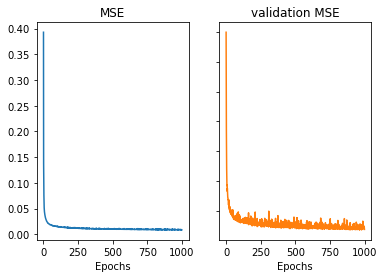

In [24]:
idx = 0

(model_3L,NNParameters) = GeneralizedNNCalibration3L(model_name[idx],num_params[idx],strikes,maturities, 42, plot_history=True)

Epoch 1/1000
240/240 [==============================] - 1s 3ms/step - loss: 0.3700 - val_loss: 0.1670
Epoch 2/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.1297 - val_loss: 0.1055
Epoch 3/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0867 - val_loss: 0.0786
Epoch 4/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0625 - val_loss: 0.0720
Epoch 5/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0529 - val_loss: 0.0519
Epoch 6/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0461 - val_loss: 0.0523
Epoch 7/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0418 - val_loss: 0.0425
Epoch 8/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0387 - val_loss: 0.0410
Epoch 9/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0370
Epoch 10/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.034

240/240 [==============================] - 0s 2ms/step - loss: 0.0153 - val_loss: 0.0202
Epoch 81/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0147 - val_loss: 0.0170
Epoch 82/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0147 - val_loss: 0.0168
Epoch 83/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0147 - val_loss: 0.0149
Epoch 84/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0145 - val_loss: 0.0174
Epoch 85/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0147 - val_loss: 0.0197
Epoch 86/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0144 - val_loss: 0.0166
Epoch 87/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0146 - val_loss: 0.0221
Epoch 88/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0146 - val_loss: 0.0182
Epoch 89/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0141 - v

240/240 [==============================] - 1s 2ms/step - loss: 0.0123 - val_loss: 0.0166
Epoch 160/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0120 - val_loss: 0.0163
Epoch 161/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0121 - val_loss: 0.0171
Epoch 162/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0125 - val_loss: 0.0121
Epoch 163/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.0128
Epoch 164/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0119 - val_loss: 0.0142
Epoch 165/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0122 - val_loss: 0.0134
Epoch 166/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0156
Epoch 167/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0121 - val_loss: 0.0134
Epoch 168/1000
240/240 [==============================] - 0s 2ms/step - loss: 0

Epoch 238/1000
240/240 [==============================] - 1s 3ms/step - loss: 0.0110 - val_loss: 0.0125
Epoch 239/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0109 - val_loss: 0.0120
Epoch 240/1000
240/240 [==============================] - 1s 3ms/step - loss: 0.0111 - val_loss: 0.0143
Epoch 241/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0108 - val_loss: 0.0134
Epoch 242/1000
240/240 [==============================] - 1s 4ms/step - loss: 0.0117 - val_loss: 0.0120
Epoch 243/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0114 - val_loss: 0.0136
Epoch 244/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0116 - val_loss: 0.0118
Epoch 245/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0106 - val_loss: 0.0138
Epoch 246/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0112 - val_loss: 0.0126
Epoch 247/1000
240/240 [==============================] - 0s 2ms

Epoch 317/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0103 - val_loss: 0.0125
Epoch 318/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0109 - val_loss: 0.0129
Epoch 319/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0111 - val_loss: 0.0128
Epoch 320/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0102 - val_loss: 0.0123
Epoch 321/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0101 - val_loss: 0.0115
Epoch 322/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0104 - val_loss: 0.0176
Epoch 323/1000
240/240 [==============================] - 1s 3ms/step - loss: 0.0109 - val_loss: 0.0219
Epoch 324/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0110 - val_loss: 0.0118
Epoch 325/1000
240/240 [==============================] - 1s 3ms/step - loss: 0.0100 - val_loss: 0.0105
Epoch 326/1000
240/240 [==============================] - 1s 3ms

Epoch 396/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0102 - val_loss: 0.0159
Epoch 397/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0097 - val_loss: 0.0133
Epoch 398/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0103 - val_loss: 0.0108
Epoch 399/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0100 - val_loss: 0.0146
Epoch 400/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0102 - val_loss: 0.0171
Epoch 401/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0108 - val_loss: 0.0156
Epoch 402/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0134
Epoch 403/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0098 - val_loss: 0.0116
Epoch 404/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0098 - val_loss: 0.0112
Epoch 405/1000
240/240 [==============================] - 0s 2ms

Epoch 475/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0105 - val_loss: 0.0110
Epoch 476/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0092 - val_loss: 0.0104
Epoch 477/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0109 - val_loss: 0.0129
Epoch 478/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0094 - val_loss: 0.0107
Epoch 479/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0097 - val_loss: 0.0140
Epoch 480/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0098 - val_loss: 0.0110
Epoch 481/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0101 - val_loss: 0.0127
Epoch 482/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0097 - val_loss: 0.0123
Epoch 483/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0094 - val_loss: 0.0114
Epoch 484/1000
240/240 [==============================] - 1s 2ms

Epoch 554/1000
240/240 [==============================] - 1s 3ms/step - loss: 0.0090 - val_loss: 0.0121
Epoch 555/1000
240/240 [==============================] - 1s 3ms/step - loss: 0.0093 - val_loss: 0.0138
Epoch 556/1000
240/240 [==============================] - 1s 3ms/step - loss: 0.0096 - val_loss: 0.0103
Epoch 557/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0095 - val_loss: 0.0102
Epoch 558/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0090 - val_loss: 0.0093
Epoch 559/1000
240/240 [==============================] - 1s 3ms/step - loss: 0.0091 - val_loss: 0.0119
Epoch 560/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0093 - val_loss: 0.0102
Epoch 561/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0091 - val_loss: 0.0102
Epoch 562/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0091 - val_loss: 0.0118
Epoch 563/1000
240/240 [==============================] - 1s 2ms

Epoch 633/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0090 - val_loss: 0.0145
Epoch 634/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0102 - val_loss: 0.0141
Epoch 635/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0090 - val_loss: 0.0102
Epoch 636/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0090 - val_loss: 0.0102
Epoch 637/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0095
Epoch 638/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0088 - val_loss: 0.0108
Epoch 639/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0090 - val_loss: 0.0108
Epoch 640/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0093 - val_loss: 0.0107
Epoch 641/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0092 - val_loss: 0.0146
Epoch 642/1000
240/240 [==============================] - 1s 3ms

Epoch 712/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0099 - val_loss: 0.0165
Epoch 713/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0090 - val_loss: 0.0091
Epoch 714/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0085 - val_loss: 0.0123
Epoch 715/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0091 - val_loss: 0.0104
Epoch 716/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0087 - val_loss: 0.0103
Epoch 717/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0087 - val_loss: 0.0102
Epoch 718/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0090 - val_loss: 0.0107
Epoch 719/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0090 - val_loss: 0.0101
Epoch 720/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0117
Epoch 721/1000
240/240 [==============================] - 0s 2ms

<Figure size 1008x288 with 0 Axes>

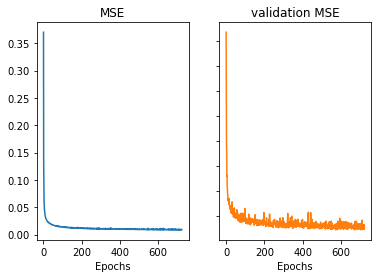

In [25]:
(model_4L,NNParameters) = GeneralizedNNCalibration4L(model_name[idx],num_params[idx],strikes,maturities, 42, plot_history=True)

In [27]:
f = gzip.GzipFile('Dataset/' + model_name[idx] + 'TrainSet.txt.gz', "r")
dat = np.load(f)
f.close()
xx = dat[:, :num_params[idx]]
yy = dat[:, num_params[idx]:]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(yy, xx, test_size=0.15, random_state=42)

ub = np.max(xx,axis=0)
lb = np.min(xx,axis=0)

scale2=StandardScaler()

scale2.fit(X_train)

[x_train_transform, x_test_transform] = [scale2.transform (X_train), scale2.transform (X_test)]

y_train_transform = np.array([myscale(y,ub,lb) for y in y_train])
y_test_transform = np.array([myscale(y,ub,lb) for y in y_test])

model_3L.evaluate(y_test_transform,x_test_transform)

188/188 [==============================] - 0s 1ms/step - loss: 0.0098


0.0097588449716568

In [28]:
model_4L.evaluate(y_test_transform,x_test_transform)

188/188 [==============================] - 0s 1ms/step - loss: 0.0103


0.010280465707182884

Epoch 1/1000
240/240 [==============================] - 1s 3ms/step - loss: 0.3809 - val_loss: 0.1710
Epoch 2/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.1397 - val_loss: 0.1163
Epoch 3/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.1010 - val_loss: 0.0843
Epoch 4/1000
240/240 [==============================] - 1s 3ms/step - loss: 0.0717 - val_loss: 0.0647
Epoch 5/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0549 - val_loss: 0.0491
Epoch 6/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0457 - val_loss: 0.0439
Epoch 7/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0397 - val_loss: 0.0397
Epoch 8/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0374
Epoch 9/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0335 - val_loss: 0.0324
Epoch 10/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.031

240/240 [==============================] - 0s 2ms/step - loss: 0.0140 - val_loss: 0.0159
Epoch 81/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0137 - val_loss: 0.0141
Epoch 82/1000
240/240 [==============================] - 1s 3ms/step - loss: 0.0140 - val_loss: 0.0171
Epoch 83/1000
240/240 [==============================] - 1s 3ms/step - loss: 0.0140 - val_loss: 0.0142
Epoch 84/1000
240/240 [==============================] - 1s 3ms/step - loss: 0.0136 - val_loss: 0.0141
Epoch 85/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0139 - val_loss: 0.0151
Epoch 86/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0164
Epoch 87/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0137 - val_loss: 0.0193
Epoch 88/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0137
Epoch 89/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0134 - v

240/240 [==============================] - 1s 2ms/step - loss: 0.0113 - val_loss: 0.0138
Epoch 160/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0118 - val_loss: 0.0124
Epoch 161/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0114 - val_loss: 0.0136
Epoch 162/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0113 - val_loss: 0.0121
Epoch 163/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0113 - val_loss: 0.0121
Epoch 164/1000
240/240 [==============================] - 1s 3ms/step - loss: 0.0112 - val_loss: 0.0142
Epoch 165/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0116 - val_loss: 0.0120
Epoch 166/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 0.0116
Epoch 167/1000
240/240 [==============================] - 1s 3ms/step - loss: 0.0111 - val_loss: 0.0121
Epoch 168/1000
240/240 [==============================] - 1s 2ms/step - loss: 0

Epoch 238/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0104 - val_loss: 0.0117
Epoch 239/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0120
Epoch 240/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0107
Epoch 241/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0114
Epoch 242/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0104 - val_loss: 0.0117
Epoch 243/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0102 - val_loss: 0.0107
Epoch 244/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0104 - val_loss: 0.0162
Epoch 245/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0105 - val_loss: 0.0171
Epoch 246/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0107 - val_loss: 0.0116
Epoch 247/1000
240/240 [==============================] - 0s 2ms

Epoch 317/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0095 - val_loss: 0.0113
Epoch 318/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0095 - val_loss: 0.0113
Epoch 319/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0097 - val_loss: 0.0104
Epoch 320/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0095 - val_loss: 0.0149
Epoch 321/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0105 - val_loss: 0.0144
Epoch 322/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0099 - val_loss: 0.0103
Epoch 323/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0093 - val_loss: 0.0099
Epoch 324/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0094 - val_loss: 0.0106
Epoch 325/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0154
Epoch 326/1000
240/240 [==============================] - 0s 2ms

Epoch 396/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0092 - val_loss: 0.0105
Epoch 397/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0094 - val_loss: 0.0100
Epoch 398/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0091 - val_loss: 0.0131
Epoch 399/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0092 - val_loss: 0.0090
Epoch 400/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0090 - val_loss: 0.0107
Epoch 401/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0091 - val_loss: 0.0138
Epoch 402/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0097 - val_loss: 0.0100
Epoch 403/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0103
Epoch 404/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0106
Epoch 405/1000
240/240 [==============================] - 0s 2ms

240/240 [==============================] - 0s 2ms/step - loss: 0.0087 - val_loss: 0.0101
Epoch 475/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0097
Epoch 476/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0108
Epoch 477/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0099
Epoch 478/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0127
Epoch 479/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0088 - val_loss: 0.0115
Epoch 480/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0088 - val_loss: 0.0103
Epoch 481/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0090 - val_loss: 0.0088
Epoch 482/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0086 - val_loss: 0.0102
Epoch 483/1000
240/240 [==============================] - 0s 2ms/step - loss: 0

Epoch 553/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0115
Epoch 554/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0085 - val_loss: 0.0084
Epoch 555/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0088
Epoch 556/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0084 - val_loss: 0.0104
Epoch 557/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0083 - val_loss: 0.0109
Epoch 558/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0085 - val_loss: 0.0114
Epoch 559/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0148
Epoch 560/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0092 - val_loss: 0.0087
Epoch 561/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0082 - val_loss: 0.0091
Epoch 562/1000
240/240 [==============================] - 0s 2ms

Epoch 632/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0082 - val_loss: 0.0094
Epoch 633/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0088 - val_loss: 0.0094
Epoch 634/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0081 - val_loss: 0.0099
Epoch 635/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0081 - val_loss: 0.0100
Epoch 636/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0087 - val_loss: 0.0116
Epoch 637/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0081 - val_loss: 0.0119
Epoch 638/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0087 - val_loss: 0.0117
Epoch 639/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0084 - val_loss: 0.0095
Epoch 640/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0082 - val_loss: 0.0092
Epoch 641/1000
240/240 [==============================] - 0s 2ms

Epoch 711/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0078 - val_loss: 0.0097
Epoch 712/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0093 - val_loss: 0.0099
Epoch 713/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0077 - val_loss: 0.0088
Epoch 714/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0078 - val_loss: 0.0086
Epoch 715/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0078 - val_loss: 0.0087
Epoch 716/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0077 - val_loss: 0.0110
Epoch 717/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0080 - val_loss: 0.0081
Epoch 718/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0080 - val_loss: 0.0082
Epoch 719/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 0.0080
Epoch 720/1000
240/240 [==============================] - 1s 2ms

Epoch 790/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0079 - val_loss: 0.0084
Epoch 791/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 0.0082
Epoch 792/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 0.0078
Epoch 793/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 794/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0077 - val_loss: 0.0090
Epoch 795/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0079 - val_loss: 0.0132
Epoch 796/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0082 - val_loss: 0.0095
Epoch 797/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0093
Epoch 798/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0095
Epoch 799/1000
240/240 [==============================] - 0s 2ms

Epoch 869/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 0.0112
Epoch 870/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0108
Epoch 871/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 0.0102
Epoch 872/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 0.0087
Epoch 873/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0095
Epoch 874/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0115
Epoch 875/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0096 - val_loss: 0.0101
Epoch 876/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0098
Epoch 877/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0074 - val_loss: 0.0072
Epoch 878/1000
240/240 [==============================] - 0s 2ms

Epoch 948/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0089 - val_loss: 0.0086
Epoch 949/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0073 - val_loss: 0.0119
Epoch 950/1000
240/240 [==============================] - 1s 3ms/step - loss: 0.0081 - val_loss: 0.0077
Epoch 951/1000
240/240 [==============================] - 1s 3ms/step - loss: 0.0071 - val_loss: 0.0112
Epoch 952/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0078 - val_loss: 0.0077
Epoch 953/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0071 - val_loss: 0.0072
Epoch 954/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0086
Epoch 955/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0077 - val_loss: 0.0121
Epoch 956/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0074 - val_loss: 0.0077
Epoch 957/1000
240/240 [==============================] - 1s 2ms

<Figure size 1008x288 with 0 Axes>

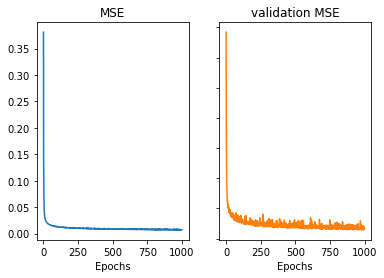

In [26]:
idx = 1

(model_3L,NNParameters) = GeneralizedNNCalibration3L(model_name[idx],num_params[idx],strikes,maturities, 42, plot_history=True)

Epoch 1/1000
240/240 [==============================] - 1s 3ms/step - loss: 0.3527 - val_loss: 0.1499
Epoch 2/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.1191 - val_loss: 0.0982
Epoch 3/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0767 - val_loss: 0.0656
Epoch 4/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0559 - val_loss: 0.0556
Epoch 5/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0468 - val_loss: 0.0451
Epoch 6/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0395
Epoch 7/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.0366
Epoch 8/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.0339
Epoch 9/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0319
Epoch 10/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.030

240/240 [==============================] - 0s 2ms/step - loss: 0.0136 - val_loss: 0.0166
Epoch 81/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0134 - val_loss: 0.0205
Epoch 82/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0137 - val_loss: 0.0158
Epoch 83/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0136 - val_loss: 0.0134
Epoch 84/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0151 - val_loss: 0.0191
Epoch 85/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0135 - val_loss: 0.0146
Epoch 86/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0131 - val_loss: 0.0188
Epoch 87/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0132
Epoch 88/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0134 - val_loss: 0.0160
Epoch 89/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0130 - v

240/240 [==============================] - 0s 2ms/step - loss: 0.0112 - val_loss: 0.0143
Epoch 160/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0116 - val_loss: 0.0126
Epoch 161/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0110 - val_loss: 0.0137
Epoch 162/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0112 - val_loss: 0.0111
Epoch 163/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0108 - val_loss: 0.0136
Epoch 164/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0107 - val_loss: 0.0157
Epoch 165/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0109 - val_loss: 0.0135
Epoch 166/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0124 - val_loss: 0.0138
Epoch 167/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0121 - val_loss: 0.0135
Epoch 168/1000
240/240 [==============================] - 0s 2ms/step - loss: 0

Epoch 238/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0125
Epoch 239/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0099 - val_loss: 0.0106
Epoch 240/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0104 - val_loss: 0.0122
Epoch 241/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0098 - val_loss: 0.0135
Epoch 242/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0109 - val_loss: 0.0156
Epoch 243/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0099 - val_loss: 0.0122
Epoch 244/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0107 - val_loss: 0.0107
Epoch 245/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0098 - val_loss: 0.0094
Epoch 246/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0096 - val_loss: 0.0120
Epoch 247/1000
240/240 [==============================] - 0s 2ms

Epoch 317/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0091 - val_loss: 0.0104
Epoch 318/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0098 - val_loss: 0.0116
Epoch 319/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0106
Epoch 320/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0134
Epoch 321/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0094 - val_loss: 0.0092
Epoch 322/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0101 - val_loss: 0.0153
Epoch 323/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0101 - val_loss: 0.0101
Epoch 324/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0091 - val_loss: 0.0116
Epoch 325/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0110
Epoch 326/1000
240/240 [==============================] - 0s 2ms

Epoch 396/1000
240/240 [==============================] - 1s 3ms/step - loss: 0.0082 - val_loss: 0.0091
Epoch 397/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0085 - val_loss: 0.0105
Epoch 398/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0087 - val_loss: 0.0087
Epoch 399/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0180
Epoch 400/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0097 - val_loss: 0.0084
Epoch 401/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0085 - val_loss: 0.0115
Epoch 402/1000
240/240 [==============================] - 1s 3ms/step - loss: 0.0102 - val_loss: 0.0114
Epoch 403/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0089
Epoch 404/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0087 - val_loss: 0.0093
Epoch 405/1000
240/240 [==============================] - 0s 2ms

240/240 [==============================] - 0s 2ms/step - loss: 0.0087 - val_loss: 0.0087
Epoch 475/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0090 - val_loss: 0.0126
Epoch 476/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 477/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0087 - val_loss: 0.0102
Epoch 478/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0088 - val_loss: 0.0085
Epoch 479/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0079 - val_loss: 0.0115
Epoch 480/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0085 - val_loss: 0.0119
Epoch 481/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0084 - val_loss: 0.0104
Epoch 482/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0095 - val_loss: 0.0084
Epoch 483/1000
240/240 [==============================] - 0s 2ms/step - loss: 0

Epoch 553/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0118
Epoch 554/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0082 - val_loss: 0.0097
Epoch 555/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0093 - val_loss: 0.0088
Epoch 556/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0083 - val_loss: 0.0081
Epoch 557/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 0.0085
Epoch 558/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0077 - val_loss: 0.0097
Epoch 559/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 0.0083
Epoch 560/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 0.0090
Epoch 561/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0117
Epoch 562/1000
240/240 [==============================] - 0s 2ms

Epoch 632/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 0.0083
Epoch 633/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 0.0080
Epoch 634/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0083
Epoch 635/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0092 - val_loss: 0.0089
Epoch 636/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 0.0158
Epoch 637/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0084 - val_loss: 0.0098
Epoch 638/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0079 - val_loss: 0.0098
Epoch 639/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 0.0107
Epoch 640/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0083 - val_loss: 0.0108
Epoch 641/1000
240/240 [==============================] - 0s 2ms

Epoch 711/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0079 - val_loss: 0.0084
Epoch 712/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0079 - val_loss: 0.0090
Epoch 713/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0077 - val_loss: 0.0081
Epoch 714/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 715/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0087 - val_loss: 0.0098
Epoch 716/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 717/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0082 - val_loss: 0.0085
Epoch 718/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0091
Epoch 719/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 0.0089
Epoch 720/1000
240/240 [==============================] - 0s 2ms

Epoch 790/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0084 - val_loss: 0.0073
Epoch 791/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0074 - val_loss: 0.0089
Epoch 792/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 0.0111
Epoch 793/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0129
Epoch 794/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0083 - val_loss: 0.0079
Epoch 795/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 796/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0081 - val_loss: 0.0158
Epoch 797/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0074 - val_loss: 0.0072
Epoch 798/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0070 - val_loss: 0.0082
Epoch 799/1000
240/240 [==============================] - 0s 2ms

Epoch 869/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0079 - val_loss: 0.0091
Epoch 870/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0077 - val_loss: 0.0072
Epoch 871/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0084
Epoch 872/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 873/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0070 - val_loss: 0.0099
Epoch 874/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0081
Epoch 875/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 0.0077
Epoch 876/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0073 - val_loss: 0.0101
Epoch 877/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0074 - val_loss: 0.0108
Epoch 878/1000
240/240 [==============================] - 0s 2ms

Epoch 948/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0085 - val_loss: 0.0081
Epoch 949/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0086
Epoch 950/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0071 - val_loss: 0.0125
Epoch 951/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0076 - val_loss: 0.0072
Epoch 952/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0142
Epoch 953/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0128
Epoch 954/1000
240/240 [==============================] - 1s 2ms/step - loss: 0.0076 - val_loss: 0.0069
Epoch 955/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0092
Epoch 956/1000
240/240 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0089
Epoch 957/1000
240/240 [==============================] - 0s 2ms

<Figure size 1008x288 with 0 Axes>

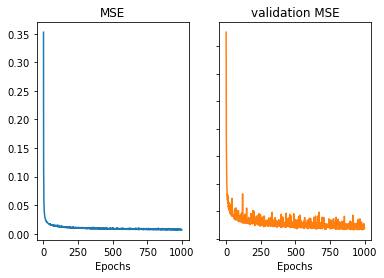

In [27]:
(model_4L,NNParameters) = GeneralizedNNCalibration4L(model_name[idx],num_params[idx],strikes,maturities, 42, plot_history=True)

In [28]:
f = gzip.GzipFile('Dataset/' + model_name[idx] + 'TrainSet.txt.gz', "r")
dat = np.load(f)
f.close()
xx = dat[:, :num_params[idx]]
yy = dat[:, num_params[idx]:]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(yy, xx, test_size=0.15, random_state=42)

ub = np.max(xx,axis=0)
lb = np.min(xx,axis=0)

scale2=StandardScaler()

scale2.fit(X_train)

[x_train_transform, x_test_transform] = [scale2.transform (X_train), scale2.transform (X_test)]

y_train_transform = np.array([myscale(y,ub,lb) for y in y_train])
y_test_transform = np.array([myscale(y,ub,lb) for y in y_test])


model_3L.evaluate(y_test_transform,x_test_transform)

188/188 [==============================] - 0s 1ms/step - loss: 0.0083


0.008293481543660164

In [29]:
model_4L.evaluate(y_test_transform,x_test_transform)

188/188 [==============================] - 0s 1ms/step - loss: 0.0077


0.0077423942275345325

Epoch 1/1000
72/72 [==============================] - 0s 5ms/step - loss: 0.7257 - val_loss: 0.3811
Epoch 2/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.2984 - val_loss: 0.2574
Epoch 3/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.2175 - val_loss: 0.2061
Epoch 4/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.1802 - val_loss: 0.1718
Epoch 5/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.1551 - val_loss: 0.1514
Epoch 6/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.1393 - val_loss: 0.1393
Epoch 7/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.1287 - val_loss: 0.1274
Epoch 8/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.1195 - val_loss: 0.1190
Epoch 9/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.1109 - val_loss: 0.1116
Epoch 10/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.1028 - val_loss: 0.1048

72/72 [==============================] - 0s 2ms/step - loss: 0.0371 - val_loss: 0.0386
Epoch 83/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0371 - val_loss: 0.0390
Epoch 84/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.0385
Epoch 85/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.0390
Epoch 86/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0372 - val_loss: 0.0384
Epoch 87/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0385
Epoch 88/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0380
Epoch 89/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0385
Epoch 90/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0386
Epoch 91/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0387
Epoc

72/72 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0340
Epoch 163/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0329 - val_loss: 0.0341
Epoch 164/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0328 - val_loss: 0.0355
Epoch 165/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0337
Epoch 166/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0338
Epoch 167/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0328 - val_loss: 0.0340
Epoch 168/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0329 - val_loss: 0.0339
Epoch 169/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0338
Epoch 170/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0331 - val_loss: 0.0342
Epoch 171/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.

72/72 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0319
Epoch 243/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0330
Epoch 244/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0319
Epoch 245/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0324
Epoch 246/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0327
Epoch 247/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0327
Epoch 248/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0329
Epoch 249/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0309 - val_loss: 0.0323
Epoch 250/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0309 - val_loss: 0.0323
Epoch 251/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0335 - val_loss: 0.

72/72 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.0310
Epoch 323/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0311
Epoch 324/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0337
Epoch 325/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0316
Epoch 326/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 0.0313
Epoch 327/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0315
Epoch 328/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0309
Epoch 329/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.0313
Epoch 330/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.0316
Epoch 331/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.

72/72 [==============================] - 0s 2ms/step - loss: 0.0288 - val_loss: 0.0303
Epoch 403/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0313
Epoch 404/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0291 - val_loss: 0.0303
Epoch 405/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.0304
Epoch 406/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0291 - val_loss: 0.0304
Epoch 407/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0317
Epoch 408/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0291 - val_loss: 0.0307
Epoch 409/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0291 - val_loss: 0.0311
Epoch 410/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.0300
Epoch 411/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0290 - val_loss: 0.

72/72 [==============================] - 0s 2ms/step - loss: 0.0282 - val_loss: 0.0302
Epoch 483/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0281 - val_loss: 0.0297
Epoch 484/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0294
Epoch 485/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0290
Epoch 486/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.0303
Epoch 487/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0294
Epoch 488/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.0299
Epoch 489/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.0296
Epoch 490/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0282 - val_loss: 0.0299
Epoch 491/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.

72/72 [==============================] - 0s 3ms/step - loss: 0.0275 - val_loss: 0.0289
Epoch 563/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0278 - val_loss: 0.0292
Epoch 564/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0276 - val_loss: 0.0289
Epoch 565/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0275 - val_loss: 0.0286
Epoch 566/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.0291
Epoch 567/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0285
Epoch 568/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.0295
Epoch 569/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0273 - val_loss: 0.0282
Epoch 570/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0271 - val_loss: 0.0299
Epoch 571/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0272 - val_loss: 0.

72/72 [==============================] - 0s 2ms/step - loss: 0.0268 - val_loss: 0.0288
Epoch 643/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0285
Epoch 644/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0267 - val_loss: 0.0276
Epoch 645/1000
72/72 [==============================] - 0s 4ms/step - loss: 0.0268 - val_loss: 0.0285
Epoch 646/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0279
Epoch 647/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.0290
Epoch 648/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0266 - val_loss: 0.0280
Epoch 649/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0266 - val_loss: 0.0277
Epoch 650/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0269 - val_loss: 0.0282
Epoch 651/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0268 - val_loss: 0.

72/72 [==============================] - 0s 3ms/step - loss: 0.0265 - val_loss: 0.0276
Epoch 723/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0281
Epoch 724/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0282
Epoch 725/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0262 - val_loss: 0.0281
Epoch 726/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.0277
Epoch 727/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0266 - val_loss: 0.0305
Epoch 728/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0265 - val_loss: 0.0274
Epoch 729/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0262 - val_loss: 0.0275
Epoch 730/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0260 - val_loss: 0.0276
Epoch 731/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0262 - val_loss: 0.

72/72 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0278
Epoch 803/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0262 - val_loss: 0.0269
Epoch 804/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0261 - val_loss: 0.0281
Epoch 805/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0261 - val_loss: 0.0271
Epoch 806/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0268
Epoch 807/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0283
Epoch 808/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0260 - val_loss: 0.0274
Epoch 809/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.0278
Epoch 810/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0261 - val_loss: 0.0272
Epoch 811/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0260 - val_loss: 0.

72/72 [==============================] - 0s 3ms/step - loss: 0.0257 - val_loss: 0.0272
Epoch 883/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0275
Epoch 884/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0274
Epoch 885/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0275
Epoch 886/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0260 - val_loss: 0.0272
Epoch 887/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0261 - val_loss: 0.0276
Epoch 888/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0274
Epoch 889/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0272
Epoch 890/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0269
Epoch 891/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.

72/72 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0274
Epoch 963/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0254 - val_loss: 0.0267
Epoch 964/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.0279
Epoch 965/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0254 - val_loss: 0.0266
Epoch 966/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.0267
Epoch 967/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0272
Epoch 968/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0269
Epoch 969/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0269
Epoch 970/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0281
Epoch 971/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.

<Figure size 1008x288 with 0 Axes>

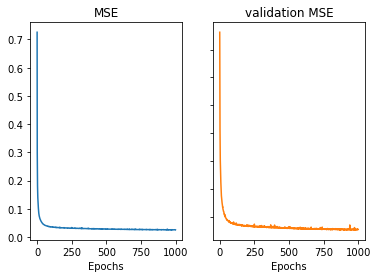

In [30]:
idx = 2

(model_3L,NNParameters) = GeneralizedNNCalibration3L(model_name[idx],num_params[idx],strikes,maturities, 42, plot_history=True)

Epoch 1/1000
72/72 [==============================] - 0s 5ms/step - loss: 0.6992 - val_loss: 0.3798
Epoch 2/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.2897 - val_loss: 0.2425
Epoch 3/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.1972 - val_loss: 0.1816
Epoch 4/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.1610 - val_loss: 0.1578
Epoch 5/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.1440 - val_loss: 0.1426
Epoch 6/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.1314 - val_loss: 0.1312
Epoch 7/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.1210 - val_loss: 0.1221
Epoch 8/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.1093 - val_loss: 0.1099
Epoch 9/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0992 - val_loss: 0.1018
Epoch 10/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0920 - val_loss: 0.0939

72/72 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0364
Epoch 83/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0375
Epoch 84/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0373
Epoch 85/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0370
Epoch 86/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0350 - val_loss: 0.0372
Epoch 87/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0367
Epoch 88/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0367
Epoch 89/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0362
Epoch 90/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0365
Epoch 91/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0370
Epoc

72/72 [==============================] - 0s 2ms/step - loss: 0.0324 - val_loss: 0.0349
Epoch 163/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0320
Epoch 164/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0317
Epoch 165/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0308
Epoch 166/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0312
Epoch 167/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0313
Epoch 168/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 0.0328
Epoch 169/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.0307
Epoch 170/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.0318
Epoch 171/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.

72/72 [==============================] - 0s 2ms/step - loss: 0.0282 - val_loss: 0.0304
Epoch 243/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0311
Epoch 244/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0310
Epoch 245/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.0313
Epoch 246/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0291 - val_loss: 0.0301
Epoch 247/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.0302
Epoch 248/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.0297
Epoch 249/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0282 - val_loss: 0.0306
Epoch 250/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.0301
Epoch 251/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.

72/72 [==============================] - 0s 3ms/step - loss: 0.0274 - val_loss: 0.0307
Epoch 323/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0278 - val_loss: 0.0287
Epoch 324/1000
72/72 [==============================] - ETA: 0s - loss: 0.027 - 0s 3ms/step - loss: 0.0271 - val_loss: 0.0283
Epoch 325/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0273 - val_loss: 0.0289
Epoch 326/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0278 - val_loss: 0.0285
Epoch 327/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0273 - val_loss: 0.0285
Epoch 328/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0274 - val_loss: 0.0287
Epoch 329/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.0288
Epoch 330/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0273 - val_loss: 0.0283
Epoch 331/1000
72/72 [==============================] - 0s 3ms/step - los

Epoch 402/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0265 - val_loss: 0.0291
Epoch 403/1000
72/72 [==============================] - 0s 4ms/step - loss: 0.0263 - val_loss: 0.0284
Epoch 404/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0269 - val_loss: 0.0285
Epoch 405/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0270 - val_loss: 0.0279
Epoch 406/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0264 - val_loss: 0.0275
Epoch 407/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0263 - val_loss: 0.0283
Epoch 408/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0269 - val_loss: 0.0277
Epoch 409/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0268 - val_loss: 0.0286
Epoch 410/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0268 - val_loss: 0.0275
Epoch 411/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0265

72/72 [==============================] - 0s 3ms/step - loss: 0.0256 - val_loss: 0.0269
Epoch 483/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0260 - val_loss: 0.0280
Epoch 484/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0267 - val_loss: 0.0279
Epoch 485/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0260 - val_loss: 0.0286
Epoch 486/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0281
Epoch 487/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0260 - val_loss: 0.0282
Epoch 488/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0260 - val_loss: 0.0272
Epoch 489/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0258 - val_loss: 0.0279
Epoch 490/1000
72/72 [==============================] - 0s 4ms/step - loss: 0.0258 - val_loss: 0.0273
Epoch 491/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0255 - val_loss: 0.

72/72 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.0278
Epoch 563/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.0272
Epoch 564/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0254 - val_loss: 0.0272
Epoch 565/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0272
Epoch 566/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0276
Epoch 567/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0282
Epoch 568/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0256 - val_loss: 0.0271
Epoch 569/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0252 - val_loss: 0.0269
Epoch 570/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0272
Epoch 571/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0256 - val_loss: 0.

72/72 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0267
Epoch 643/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0268
Epoch 644/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0254 - val_loss: 0.0266
Epoch 645/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0269
Epoch 646/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0270 - val_loss: 0.0280
Epoch 647/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0255 - val_loss: 0.0283
Epoch 648/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0250 - val_loss: 0.0265
Epoch 649/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0254 - val_loss: 0.0270
Epoch 650/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0252 - val_loss: 0.0264
Epoch 651/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0252 - val_loss: 0.

72/72 [==============================] - 0s 2ms/step - loss: 0.0262 - val_loss: 0.0271
Epoch 723/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0272
Epoch 724/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0254 - val_loss: 0.0286
Epoch 725/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0252 - val_loss: 0.0280
Epoch 726/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0264
Epoch 727/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0262
Epoch 728/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0281
Epoch 729/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0262
Epoch 730/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0270
Epoch 731/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.

72/72 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0268
Epoch 803/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0247 - val_loss: 0.0268
Epoch 804/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0268
Epoch 805/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0267
Epoch 806/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0278
Epoch 807/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0266
Epoch 808/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.0262
Epoch 809/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0266
Epoch 810/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0247 - val_loss: 0.0270
Epoch 811/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0247 - val_loss: 0.

72/72 [==============================] - 0s 2ms/step - loss: 0.0247 - val_loss: 0.0273
Epoch 883/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.0258
Epoch 884/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0246 - val_loss: 0.0264
Epoch 885/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0277
Epoch 886/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0270
Epoch 887/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.0259
Epoch 888/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0266
Epoch 889/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0261
Epoch 890/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0260
Epoch 891/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.

72/72 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.0262
Epoch 963/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.0263
Epoch 964/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0259
Epoch 965/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0271
Epoch 966/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.0263
Epoch 967/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.0286
Epoch 968/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0258
Epoch 969/1000
72/72 [==============================] - 0s 4ms/step - loss: 0.0246 - val_loss: 0.0259
Epoch 970/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.0246 - val_loss: 0.0257
Epoch 971/1000
72/72 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.

<Figure size 1008x288 with 0 Axes>

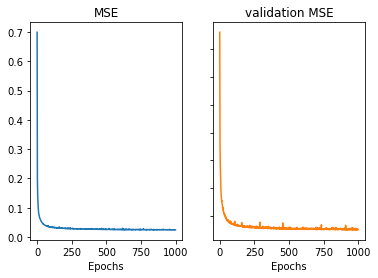

In [31]:
(model_4L,NNParameters) = GeneralizedNNCalibration4L(model_name[idx],num_params[idx],strikes,maturities, 42, plot_history=True)

In [32]:
f = gzip.GzipFile('Dataset/' + model_name[idx] + 'TrainSet.txt.gz', "r")
dat = np.load(f)
f.close()
xx = dat[:, :num_params[idx]]
yy = dat[:, num_params[idx]:]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(yy, xx, test_size=0.15, random_state=42)

ub = np.max(xx,axis=0)
lb = np.min(xx,axis=0)

scale2=StandardScaler()

scale2.fit(X_train)

[x_train_transform, x_test_transform] = [scale2.transform (X_train), scale2.transform (X_test)]

y_train_transform = np.array([myscale(y,ub,lb) for y in y_train])
y_test_transform = np.array([myscale(y,ub,lb) for y in y_test])


model_3L.evaluate(y_test_transform,x_test_transform)

57/57 [==============================] - 0s 1ms/step - loss: 0.0250


0.024981744587421417

In [33]:
model_4L.evaluate(y_test_transform,x_test_transform)

57/57 [==============================] - 0s 1ms/step - loss: 0.0239


0.023898251354694366

Epoch 1/1000
619/619 [==============================] - 2s 3ms/step - loss: 0.2133 - val_loss: 0.0766
Epoch 2/1000
619/619 [==============================] - 2s 3ms/step - loss: 0.0584 - val_loss: 0.0440
Epoch 3/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0376 - val_loss: 0.0330
Epoch 4/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0301 - val_loss: 0.0279
Epoch 5/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0265 - val_loss: 0.0246
Epoch 6/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0238 - val_loss: 0.0249
Epoch 7/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0222 - val_loss: 0.0215
Epoch 8/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0205 - val_loss: 0.0208
Epoch 9/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0195 - val_loss: 0.0201
Epoch 10/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.018

619/619 [==============================] - 2s 3ms/step - loss: 0.0086 - val_loss: 0.0079
Epoch 81/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0086 - val_loss: 0.0083
Epoch 82/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0089 - val_loss: 0.0085
Epoch 83/1000
619/619 [==============================] - 2s 3ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 84/1000
619/619 [==============================] - 2s 3ms/step - loss: 0.0085 - val_loss: 0.0074
Epoch 85/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0083 - val_loss: 0.0084
Epoch 86/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0087 - val_loss: 0.0101
Epoch 87/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0083 - val_loss: 0.0077
Epoch 88/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0080 - val_loss: 0.0086
Epoch 89/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0084 - v

619/619 [==============================] - 1s 2ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 160/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0068 - val_loss: 0.0063
Epoch 161/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0068 - val_loss: 0.0067
Epoch 162/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0069 - val_loss: 0.0062
Epoch 163/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 164/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0073 - val_loss: 0.0062
Epoch 165/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0063 - val_loss: 0.0060
Epoch 166/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0067 - val_loss: 0.0090
Epoch 167/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0066 - val_loss: 0.0060
Epoch 168/1000
619/619 [==============================] - 1s 2ms/step - loss: 0

619/619 [==============================] - 1s 2ms/step - loss: 0.0058 - val_loss: 0.0053
Epoch 238/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0056 - val_loss: 0.0057
Epoch 239/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0057 - val_loss: 0.0055
Epoch 240/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0056 - val_loss: 0.0062
Epoch 241/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0059 - val_loss: 0.0070
Epoch 242/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0064 - val_loss: 0.0052
Epoch 243/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0059 - val_loss: 0.0048
Epoch 244/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0059 - val_loss: 0.0052
Epoch 245/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0056 - val_loss: 0.0067
Epoch 246/1000
619/619 [==============================] - 1s 2ms/step - loss: 0

Epoch 316/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 317/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 318/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0055 - val_loss: 0.0046
Epoch 319/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0056 - val_loss: 0.0049
Epoch 320/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0055 - val_loss: 0.0061
Epoch 321/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0058 - val_loss: 0.0059
Epoch 322/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0047
Epoch 323/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0056 - val_loss: 0.0044
Epoch 324/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0053 - val_loss: 0.0055
Epoch 325/1000
619/619 [==============================] - 1s 2ms

Epoch 395/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0049 - val_loss: 0.0052
Epoch 396/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 397/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0060
Epoch 398/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 399/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0056 - val_loss: 0.0045
Epoch 400/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0049 - val_loss: 0.0041
Epoch 401/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0047
Epoch 402/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0049 - val_loss: 0.0055
Epoch 403/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 404/1000
619/619 [==============================] - 1s 2ms

Epoch 474/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0053
Epoch 475/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0056
Epoch 476/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 477/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0044
Epoch 478/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0049 - val_loss: 0.0064
Epoch 479/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 480/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0054 - val_loss: 0.0057
Epoch 481/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0048 - val_loss: 0.0061
Epoch 482/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 483/1000
619/619 [==============================] - 1s 2ms

Epoch 553/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0048 - val_loss: 0.0041
Epoch 554/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0052 - val_loss: 0.0060
Epoch 555/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 556/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 557/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0049 - val_loss: 0.0043
Epoch 558/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0062
Epoch 559/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 560/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0068
Epoch 561/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 562/1000
619/619 [==============================] - 1s 2ms

Epoch 632/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0053
Epoch 633/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0046 - val_loss: 0.0067
Epoch 634/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 635/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0044
Epoch 636/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0047 - val_loss: 0.0040
Epoch 637/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 638/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0053
Epoch 639/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 640/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 641/1000
619/619 [==============================] - 1s 2ms

Epoch 711/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 712/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0061
Epoch 713/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0060
Epoch 714/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0046
Epoch 715/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0054
Epoch 716/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0047 - val_loss: 0.0073
Epoch 717/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0049 - val_loss: 0.0041
Epoch 718/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 719/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0048 - val_loss: 0.0043
Epoch 720/1000
619/619 [==============================] - 1s 2ms

Epoch 790/1000
619/619 [==============================] - 2s 3ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 791/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0049 - val_loss: 0.0046
Epoch 792/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0038
Epoch 793/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0052
Epoch 794/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 795/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0048 - val_loss: 0.0059
Epoch 796/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 797/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 798/1000
619/619 [==============================] - 2s 4ms/step - loss: 0.0045 - val_loss: 0.0057
Epoch 799/1000
619/619 [==============================] - 2s 4ms

619/619 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0058
Epoch 869/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0047 - val_loss: 0.0054
Epoch 870/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 871/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0060
Epoch 872/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0078
Epoch 873/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0046 - val_loss: 0.0038
Epoch 874/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0048 - val_loss: 0.0056
Epoch 875/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 876/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 877/1000
619/619 [==============================] - 1s 2ms/step - loss: 0

Epoch 947/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0051
Epoch 948/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 949/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 950/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 951/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 952/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0067
Epoch 953/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 954/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 955/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0036
Epoch 956/1000
619/619 [==============================] - 1s 2ms

<Figure size 1008x288 with 0 Axes>

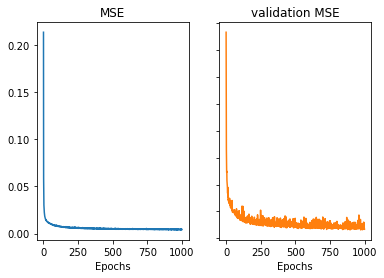

In [34]:
idx = 3

(model_3L,NNParameters) = GeneralizedNNCalibration3L(model_name[idx],num_params[idx],strikes,maturities, 18, plot_history=True)

Epoch 1/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.1852 - val_loss: 0.0603
Epoch 2/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0431 - val_loss: 0.0336
Epoch 3/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0296 - val_loss: 0.0256
Epoch 4/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0247 - val_loss: 0.0244
Epoch 5/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0214 - val_loss: 0.0202
Epoch 6/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0201 - val_loss: 0.0199
Epoch 7/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0188 - val_loss: 0.0180
Epoch 8/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0178 - val_loss: 0.0186
Epoch 9/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0169 - val_loss: 0.0167
Epoch 10/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.016

Epoch 159/1000
619/619 [==============================] - 1s 1ms/step - loss: 0.0067 - val_loss: 0.0065
Epoch 160/1000
619/619 [==============================] - 1s 1ms/step - loss: 0.0065 - val_loss: 0.0054
Epoch 161/1000
619/619 [==============================] - 1s 1ms/step - loss: 0.0073 - val_loss: 0.0104
Epoch 162/1000
619/619 [==============================] - 1s 1ms/step - loss: 0.0065 - val_loss: 0.0087
Epoch 163/1000
619/619 [==============================] - 1s 1ms/step - loss: 0.0066 - val_loss: 0.0111
Epoch 164/1000
619/619 [==============================] - 1s 1ms/step - loss: 0.0071 - val_loss: 0.0068
Epoch 165/1000
619/619 [==============================] - 1s 1ms/step - loss: 0.0065 - val_loss: 0.0074
Epoch 166/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0066 - val_loss: 0.0089
Epoch 167/1000
619/619 [==============================] - 1s 1ms/step - loss: 0.0069 - val_loss: 0.0053
Epoch 168/1000
619/619 [==============================] - 1s 1ms

Epoch 238/1000
619/619 [==============================] - 1s 1ms/step - loss: 0.0062 - val_loss: 0.0068
Epoch 239/1000
619/619 [==============================] - 1s 1ms/step - loss: 0.0067 - val_loss: 0.0060
Epoch 240/1000
619/619 [==============================] - 1s 1ms/step - loss: 0.0063 - val_loss: 0.0074
Epoch 241/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0059 - val_loss: 0.0051
Epoch 242/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0064 - val_loss: 0.0078
Epoch 243/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0063 - val_loss: 0.0059
Epoch 244/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0061 - val_loss: 0.0043
Epoch 245/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 0.0045
Epoch 246/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0065 - val_loss: 0.0058
Epoch 247/1000
619/619 [==============================] - 1s 2ms

Epoch 317/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0059 - val_loss: 0.0047
Epoch 318/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0054 - val_loss: 0.0045
Epoch 319/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0056 - val_loss: 0.0047
Epoch 320/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 321/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0059 - val_loss: 0.0050
Epoch 322/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 323/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0056 - val_loss: 0.0044
Epoch 324/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0061 - val_loss: 0.0072
Epoch 325/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 326/1000
619/619 [==============================] - 1s 2ms

Epoch 396/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0055 - val_loss: 0.0050
Epoch 397/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0056 - val_loss: 0.0066
Epoch 398/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0056 - val_loss: 0.0041
Epoch 399/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0057 - val_loss: 0.0046
Epoch 400/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0055 - val_loss: 0.0077
Epoch 401/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0053 - val_loss: 0.0047
Epoch 402/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0061 - val_loss: 0.0045
Epoch 403/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0057 - val_loss: 0.0058
Epoch 404/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0055 - val_loss: 0.0048
Epoch 405/1000
619/619 [==============================] - 1s 2ms

Epoch 475/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0048 - val_loss: 0.0050
Epoch 476/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0057 - val_loss: 0.0093
Epoch 477/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0055 - val_loss: 0.0040
Epoch 478/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0053 - val_loss: 0.0056
Epoch 479/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0052 - val_loss: 0.0048
Epoch 480/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0056 - val_loss: 0.0047
Epoch 481/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0054 - val_loss: 0.0048
Epoch 482/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0053 - val_loss: 0.0061
Epoch 483/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0052 - val_loss: 0.0058
Epoch 484/1000
619/619 [==============================] - 1s 2ms

Epoch 554/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0053 - val_loss: 0.0043
Epoch 555/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0041
Epoch 556/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0047
Epoch 557/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0053 - val_loss: 0.0062
Epoch 558/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0055 - val_loss: 0.0077
Epoch 559/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0043
Epoch 560/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0049 - val_loss: 0.0040
Epoch 561/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0062
Epoch 562/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0055 - val_loss: 0.0061
Epoch 563/1000
619/619 [==============================] - 1s 1ms

Epoch 633/1000
619/619 [==============================] - 1s 1ms/step - loss: 0.0047 - val_loss: 0.0071
Epoch 634/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 635/1000
619/619 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0041
Epoch 636/1000
619/619 [==============================] - 1s 1ms/step - loss: 0.0049 - val_loss: 0.0057
Epoch 637/1000
619/619 [==============================] - 1s 1ms/step - loss: 0.0046 - val_loss: 0.0061
Epoch 638/1000
619/619 [==============================] - 1s 1ms/step - loss: 0.0052 - val_loss: 0.0048
Epoch 639/1000
619/619 [==============================] - 1s 1ms/step - loss: 0.0052 - val_loss: 0.0047
Epoch 640/1000
619/619 [==============================] - 1s 1ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 641/1000
619/619 [==============================] - 1s 1ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 642/1000
619/619 [==============================] - 1s 1ms

<Figure size 1008x288 with 0 Axes>

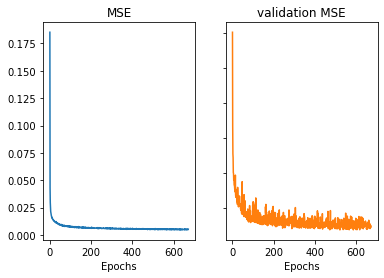

In [34]:
(model_4L,NNParameters) = GeneralizedNNCalibration4L(model_name[idx],num_params[idx],strikes,maturities, 18, plot_history=True)

In [35]:
f = gzip.GzipFile('Dataset/' + model_name[idx] + 'TrainSet.txt.gz', "r")
dat = np.load(f)
f.close()
xx = dat[:, :num_params[idx]]
yy = dat[:, num_params[idx]:]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(yy, xx, test_size=0.15, random_state=42)

ub = np.max(xx,axis=0)
lb = np.min(xx,axis=0)

scale2=StandardScaler()

scale2.fit(X_train)

[x_train_transform, x_test_transform] = [scale2.transform (X_train), scale2.transform (X_test)]

y_train_transform = np.array([myscale(y,ub,lb) for y in y_train])
y_test_transform = np.array([myscale(y,ub,lb) for y in y_test])


model_3L.evaluate(y_test_transform,x_test_transform)

486/486 [==============================] - 1s 1ms/step - loss: 0.0033


0.003326958976686001

In [36]:
model_4L.evaluate(y_test_transform,x_test_transform)

ValueError: in user code:

    C:\Users\ariel\anaconda3\envs\PythonCPU\lib\site-packages\tensorflow\python\keras\engine\training.py:1224 test_function  *
        return step_function(self, iterator)
    C:\Users\ariel\anaconda3\envs\PythonCPU\lib\site-packages\tensorflow\python\keras\engine\training.py:1215 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\ariel\anaconda3\envs\PythonCPU\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\ariel\anaconda3\envs\PythonCPU\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\ariel\anaconda3\envs\PythonCPU\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\ariel\anaconda3\envs\PythonCPU\lib\site-packages\tensorflow\python\keras\engine\training.py:1208 run_step  **
        outputs = model.test_step(data)
    C:\Users\ariel\anaconda3\envs\PythonCPU\lib\site-packages\tensorflow\python\keras\engine\training.py:1174 test_step
        y_pred = self(x, training=False)
    C:\Users\ariel\anaconda3\envs\PythonCPU\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Users\ariel\anaconda3\envs\PythonCPU\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_13 is incompatible with the layer: expected axis -1 of input shape to have value 5 but received input with shape [None, 4]


In [ ]:
idx = 4

(model_3L,NNParameters) = GeneralizedNNCalibration3L(model_name[idx],num_params[idx],strikes,maturities, 42, plot_history=True)

In [ ]:
(model_4L,NNParameters) = GeneralizedNNCalibration4L(model_name[idx],num_params[idx],strikes,maturities, 42, plot_history=True)

In [ ]:
f = gzip.GzipFile('Dataset/' + model_name[idx] + 'TrainSet.txt.gz', "r")
dat = np.load(f)
f.close()
xx = dat[:, :num_params[idx]]
yy = dat[:, num_params[idx]:]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(yy, xx, test_size=0.15, random_state=42)

ub = np.max(xx,axis=0)
lb = np.min(xx,axis=0)

scale2=StandardScaler()

scale2.fit(X_train)

[x_train_transform, x_test_transform] = [scale2.transform (X_train), scale2.transform (X_test)]

y_train_transform = np.array([myscale(y,ub,lb) for y in y_train])
y_test_transform = np.array([myscale(y,ub,lb) for y in y_test])


model_3L.evaluate(y_test_transform,x_test_transform)

In [ ]:
model_4L.evaluate(y_test_transform,x_test_transform)

Epoch 1/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.3409 - val_loss: 0.1587
Epoch 2/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.1295 - val_loss: 0.1130
Epoch 3/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.1023 - val_loss: 0.0943
Epoch 4/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0882 - val_loss: 0.0858
Epoch 5/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0794 - val_loss: 0.0780
Epoch 6/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0733 - val_loss: 0.0721
Epoch 7/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0689 - val_loss: 0.0688
Epoch 8/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0653 - val_loss: 0.0652
Epoch 9/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0623 - val_loss: 0.0625
Epoch 10/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.060

479/479 [==============================] - 1s 1ms/step - loss: 0.0359 - val_loss: 0.0363
Epoch 81/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0356 - val_loss: 0.0371
Epoch 82/1000
479/479 [==============================] - 1s 1ms/step - loss: 0.0357 - val_loss: 0.0383
Epoch 83/1000
479/479 [==============================] - 1s 1ms/step - loss: 0.0353 - val_loss: 0.0376
Epoch 84/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0354 - val_loss: 0.0373
Epoch 85/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0353 - val_loss: 0.0387
Epoch 86/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0351 - val_loss: 0.0356
Epoch 87/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0351 - val_loss: 0.0353
Epoch 88/1000
479/479 [==============================] - 1s 1ms/step - loss: 0.0351 - val_loss: 0.0378
Epoch 89/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0349 - v

479/479 [==============================] - 1s 2ms/step - loss: 0.0316 - val_loss: 0.0317
Epoch 160/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0315 - val_loss: 0.0337
Epoch 161/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0313 - val_loss: 0.0331
Epoch 162/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0316 - val_loss: 0.0318
Epoch 163/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0315 - val_loss: 0.0317
Epoch 164/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0311 - val_loss: 0.0373
Epoch 165/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0315 - val_loss: 0.0325
Epoch 166/1000
479/479 [==============================] - 1s 1ms/step - loss: 0.0312 - val_loss: 0.0328
Epoch 167/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0313 - val_loss: 0.0329
Epoch 168/1000
479/479 [==============================] - 1s 2ms/step - loss: 0

Epoch 238/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0294 - val_loss: 0.0309
Epoch 239/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0292 - val_loss: 0.0301
Epoch 240/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0293 - val_loss: 0.0293
Epoch 241/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0292 - val_loss: 0.0310
Epoch 242/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0292 - val_loss: 0.0299
Epoch 243/1000
479/479 [==============================] - 1s 1ms/step - loss: 0.0293 - val_loss: 0.0333
Epoch 244/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0293 - val_loss: 0.0302
Epoch 245/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0291 - val_loss: 0.0316
Epoch 246/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0291 - val_loss: 0.0300
Epoch 247/1000
479/479 [==============================] - 1s 2ms

Epoch 317/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0279 - val_loss: 0.0287
Epoch 318/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0281 - val_loss: 0.0287
Epoch 319/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0283 - val_loss: 0.0290
Epoch 320/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0283 - val_loss: 0.0309
Epoch 321/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0280 - val_loss: 0.0293
Epoch 322/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0278 - val_loss: 0.0290
Epoch 323/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0280 - val_loss: 0.0285
Epoch 324/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0280 - val_loss: 0.0286
Epoch 325/1000
479/479 [==============================] - 1s 1ms/step - loss: 0.0280 - val_loss: 0.0294
Epoch 326/1000
479/479 [==============================] - 1s 1ms

Epoch 396/1000
479/479 [==============================] - 1s 1ms/step - loss: 0.0272 - val_loss: 0.0282
Epoch 397/1000
479/479 [==============================] - 1s 1ms/step - loss: 0.0273 - val_loss: 0.0279
Epoch 398/1000
479/479 [==============================] - 1s 1ms/step - loss: 0.0270 - val_loss: 0.0271
Epoch 399/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0270 - val_loss: 0.0285
Epoch 400/1000
479/479 [==============================] - 1s 1ms/step - loss: 0.0274 - val_loss: 0.0278
Epoch 401/1000
479/479 [==============================] - 1s 1ms/step - loss: 0.0272 - val_loss: 0.0278
Epoch 402/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0270 - val_loss: 0.0283
Epoch 403/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0271 - val_loss: 0.0293
Epoch 404/1000
479/479 [==============================] - 1s 1ms/step - loss: 0.0272 - val_loss: 0.0285
Epoch 405/1000
479/479 [==============================] - 1s 2ms

Epoch 475/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0265 - val_loss: 0.0267
Epoch 476/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0265 - val_loss: 0.0270
Epoch 477/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0262 - val_loss: 0.0277
Epoch 478/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0266 - val_loss: 0.0274
Epoch 479/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0264 - val_loss: 0.0295
Epoch 480/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0263 - val_loss: 0.0288
Epoch 481/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0265 - val_loss: 0.0289
Epoch 482/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0263 - val_loss: 0.0317
Epoch 483/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0263 - val_loss: 0.0288
Epoch 484/1000
479/479 [==============================] - 1s 2ms

Epoch 554/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0260 - val_loss: 0.0272
Epoch 555/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0260 - val_loss: 0.0261
Epoch 556/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0257 - val_loss: 0.0266
Epoch 557/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0259 - val_loss: 0.0266
Epoch 558/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0258 - val_loss: 0.0262
Epoch 559/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0260 - val_loss: 0.0274
Epoch 560/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0259 - val_loss: 0.0272
Epoch 561/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0258 - val_loss: 0.0301
Epoch 562/1000
479/479 [==============================] - 1s 1ms/step - loss: 0.0257 - val_loss: 0.0275
Epoch 563/1000
479/479 [==============================] - 1s 2ms

479/479 [==============================] - 1s 2ms/step - loss: 0.0255 - val_loss: 0.0267
Epoch 633/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0254 - val_loss: 0.0259
Epoch 634/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0254 - val_loss: 0.0268
Epoch 635/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0254 - val_loss: 0.0264
Epoch 636/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0253 - val_loss: 0.0268
Epoch 637/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0253 - val_loss: 0.0266
Epoch 638/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0254 - val_loss: 0.0281
Epoch 639/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0252 - val_loss: 0.0284
Epoch 640/1000
479/479 [==============================] - 1s 1ms/step - loss: 0.0255 - val_loss: 0.0270
Epoch 641/1000
479/479 [==============================] - 1s 2ms/step - loss: 0

Epoch 711/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0250 - val_loss: 0.0291
Epoch 712/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0251 - val_loss: 0.0258
Epoch 713/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0249 - val_loss: 0.0262
Epoch 714/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0248 - val_loss: 0.0263
Epoch 715/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0250 - val_loss: 0.0268
Epoch 716/1000
479/479 [==============================] - 1s 1ms/step - loss: 0.0249 - val_loss: 0.0262
Epoch 717/1000
479/479 [==============================] - 1s 1ms/step - loss: 0.0250 - val_loss: 0.0251
Epoch 718/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0248 - val_loss: 0.0268
Epoch 719/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0250 - val_loss: 0.0252
Epoch 720/1000
479/479 [==============================] - 1s 1ms

479/479 [==============================] - 1s 3ms/step - loss: 0.0245 - val_loss: 0.0262
Epoch 790/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0247 - val_loss: 0.0259
Epoch 791/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0247 - val_loss: 0.0249
Epoch 792/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0246 - val_loss: 0.0262
Epoch 793/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0245 - val_loss: 0.0247 - ETA: 0s - loss: 0.02
Epoch 794/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0245 - val_loss: 0.0266
Epoch 795/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0248 - val_loss: 0.0267
Epoch 796/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0245 - val_loss: 0.0264
Epoch 797/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0246 - val_loss: 0.0263
Epoch 798/1000
479/479 [==============================] 

479/479 [==============================] - 1s 3ms/step - loss: 0.0244 - val_loss: 0.0250
Epoch 868/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0242 - val_loss: 0.0247
Epoch 869/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0246 - val_loss: 0.0264
Epoch 870/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0241 - val_loss: 0.0247
Epoch 871/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0240 - val_loss: 0.0245
Epoch 872/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0243 - val_loss: 0.0268
Epoch 873/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0243 - val_loss: 0.0261
Epoch 874/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0241 - val_loss: 0.0288
Epoch 875/1000
479/479 [==============================] - 2s 4ms/step - loss: 0.0243 - val_loss: 0.0251
Epoch 876/1000
479/479 [==============================] - 1s 2ms/step - loss: 0

Epoch 946/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0238 - val_loss: 0.0254
Epoch 947/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0240 - val_loss: 0.0249
Epoch 948/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0238 - val_loss: 0.0281
Epoch 949/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0241 - val_loss: 0.0244
Epoch 950/1000
479/479 [==============================] - 1s 1ms/step - loss: 0.0240 - val_loss: 0.0247
Epoch 951/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0241 - val_loss: 0.0243
Epoch 952/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0242 - val_loss: 0.0245
Epoch 953/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0240 - val_loss: 0.0271
Epoch 954/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0238 - val_loss: 0.0242
Epoch 955/1000
479/479 [==============================] - 1s 2ms

<Figure size 1008x288 with 0 Axes>

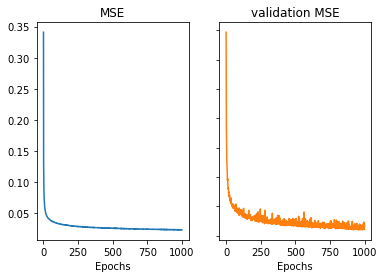

In [8]:
idx = 5

(model_3L,NNParameters) = GeneralizedNNCalibration3L(model_name[idx],num_params[idx],strikes,maturities, 42, plot_history=True)

Epoch 1/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.3249 - val_loss: 0.1602
Epoch 2/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.1300 - val_loss: 0.1127
Epoch 3/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.1000 - val_loss: 0.0936
Epoch 4/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0856 - val_loss: 0.0820
Epoch 5/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0768 - val_loss: 0.0742
Epoch 6/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0706 - val_loss: 0.0744
Epoch 7/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0664 - val_loss: 0.0662
Epoch 8/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0629 - val_loss: 0.0640
Epoch 9/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0601 - val_loss: 0.0608
Epoch 10/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.057

479/479 [==============================] - 1s 2ms/step - loss: 0.0337 - val_loss: 0.0359
Epoch 81/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0335 - val_loss: 0.0343
Epoch 82/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0335 - val_loss: 0.0390
Epoch 83/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0335 - val_loss: 0.0363
Epoch 84/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0334 - val_loss: 0.0347
Epoch 85/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0331 - val_loss: 0.0350
Epoch 86/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0332 - val_loss: 0.0357
Epoch 87/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0332 - val_loss: 0.0373
Epoch 88/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0329 - val_loss: 0.0346
Epoch 89/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0330 - v

479/479 [==============================] - 1s 2ms/step - loss: 0.0294 - val_loss: 0.0312
Epoch 160/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0292 - val_loss: 0.0333
Epoch 161/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0293 - val_loss: 0.0303
Epoch 162/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0292 - val_loss: 0.0326
Epoch 163/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0295 - val_loss: 0.0312
Epoch 164/1000
479/479 [==============================] - 1s 1ms/step - loss: 0.0292 - val_loss: 0.0329
Epoch 165/1000
479/479 [==============================] - 1s 1ms/step - loss: 0.0291 - val_loss: 0.0296
Epoch 166/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0290 - val_loss: 0.0293
Epoch 167/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0289 - val_loss: 0.0305
Epoch 168/1000
479/479 [==============================] - 1s 2ms/step - loss: 0

Epoch 238/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0270 - val_loss: 0.0289
Epoch 239/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0271 - val_loss: 0.0291
Epoch 240/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0270 - val_loss: 0.0288
Epoch 241/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0268 - val_loss: 0.0303
Epoch 242/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0271 - val_loss: 0.0285
Epoch 243/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0268 - val_loss: 0.0277 loss: 0.
Epoch 244/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0268 - val_loss: 0.0271
Epoch 245/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0267 - val_loss: 0.0276
Epoch 246/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0269 - val_loss: 0.0280
Epoch 247/1000
479/479 [==============================]

479/479 [==============================] - 1s 2ms/step - loss: 0.0255 - val_loss: 0.0255
Epoch 317/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0255 - val_loss: 0.0264
Epoch 318/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0256 - val_loss: 0.0270
Epoch 319/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0255 - val_loss: 0.0258
Epoch 320/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0255 - val_loss: 0.0280
Epoch 321/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0254 - val_loss: 0.0263
Epoch 322/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0255 - val_loss: 0.0267
Epoch 323/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0254 - val_loss: 0.0300
Epoch 324/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0255 - val_loss: 0.0269
Epoch 325/1000
479/479 [==============================] - 1s 2ms/step - loss: 0

Epoch 395/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0246 - val_loss: 0.0257
Epoch 396/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0246 - val_loss: 0.0267
Epoch 397/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0247 - val_loss: 0.0272
Epoch 398/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0244 - val_loss: 0.0270
Epoch 399/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0245 - val_loss: 0.0251
Epoch 400/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0245 - val_loss: 0.0268
Epoch 401/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0245 - val_loss: 0.0252
Epoch 402/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0244 - val_loss: 0.0257
Epoch 403/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0244 - val_loss: 0.0256
Epoch 404/1000
479/479 [==============================] - 1s 2ms

Epoch 474/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0235 - val_loss: 0.0291
Epoch 475/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0240 - val_loss: 0.0236
Epoch 476/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0238 - val_loss: 0.0251
Epoch 477/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0237 - val_loss: 0.0257
Epoch 478/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0237 - val_loss: 0.0250
Epoch 479/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0237 - val_loss: 0.0246
Epoch 480/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0236 - val_loss: 0.0247
Epoch 481/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0237 - val_loss: 0.0257
Epoch 482/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0238 - val_loss: 0.0250
Epoch 483/1000
479/479 [==============================] - 1s 2ms

Epoch 553/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0230 - val_loss: 0.0257
Epoch 554/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0232 - val_loss: 0.0245
Epoch 555/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0231 - val_loss: 0.0237
Epoch 556/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0230 - val_loss: 0.0242
Epoch 557/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0232 - val_loss: 0.0269
Epoch 558/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0234 - val_loss: 0.0256
Epoch 559/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0229 - val_loss: 0.0235
Epoch 560/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0231 - val_loss: 0.0244
Epoch 561/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0230 - val_loss: 0.0286
Epoch 562/1000
479/479 [==============================] - 1s 2ms

479/479 [==============================] - 1s 2ms/step - loss: 0.0226 - val_loss: 0.0263
Epoch 632/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0225 - val_loss: 0.0233
Epoch 633/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0226 - val_loss: 0.0292
Epoch 634/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0227 - val_loss: 0.0234
Epoch 635/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0226 - val_loss: 0.0265
Epoch 636/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0225 - val_loss: 0.0265
Epoch 637/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0225 - val_loss: 0.0238
Epoch 638/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0226 - val_loss: 0.0234
Epoch 639/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0225 - val_loss: 0.0295
Epoch 640/1000
479/479 [==============================] - 1s 3ms/step - loss: 0

Epoch 710/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0220 - val_loss: 0.0227
Epoch 711/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0222 - val_loss: 0.0268
Epoch 712/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0221 - val_loss: 0.0236
Epoch 713/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0220 - val_loss: 0.0246
Epoch 714/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0220 - val_loss: 0.0230
Epoch 715/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0221 - val_loss: 0.0235
Epoch 716/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0220 - val_loss: 0.0222
Epoch 717/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0221 - val_loss: 0.0275
Epoch 718/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0221 - val_loss: 0.0225
Epoch 719/1000
479/479 [==============================] - 1s 2ms

Epoch 789/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0221 - val_loss: 0.0231
Epoch 790/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0215 - val_loss: 0.0235
Epoch 791/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0217 - val_loss: 0.0275
Epoch 792/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0217 - val_loss: 0.0229
Epoch 793/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0218 - val_loss: 0.0233
Epoch 794/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0217 - val_loss: 0.0230
Epoch 795/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0217 - val_loss: 0.0254
Epoch 796/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0217 - val_loss: 0.0249
Epoch 797/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0221 - val_loss: 0.0227
Epoch 798/1000
479/479 [==============================] - 1s 2ms

Epoch 868/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0215 - val_loss: 0.0235
Epoch 869/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0216 - val_loss: 0.0245
Epoch 870/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0214 - val_loss: 0.0264
Epoch 871/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0214 - val_loss: 0.0217
Epoch 872/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0212 - val_loss: 0.0229
Epoch 873/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0214 - val_loss: 0.0218
Epoch 874/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0215 - val_loss: 0.0246
Epoch 875/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0214 - val_loss: 0.0223
Epoch 876/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0213 - val_loss: 0.0226
Epoch 877/1000
479/479 [==============================] - 1s 2ms

479/479 [==============================] - 1s 2ms/step - loss: 0.0213 - val_loss: 0.0214
Epoch 947/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0210 - val_loss: 0.0277
Epoch 948/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0210 - val_loss: 0.0230
Epoch 949/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0211 - val_loss: 0.0218
Epoch 950/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0210 - val_loss: 0.0255
Epoch 951/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0212 - val_loss: 0.0232
Epoch 952/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0210 - val_loss: 0.0261
Epoch 953/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0212 - val_loss: 0.0240
Epoch 954/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0212 - val_loss: 0.0224
Epoch 955/1000
479/479 [==============================] - 1s 2ms/step - loss: 0

<Figure size 1008x288 with 0 Axes>

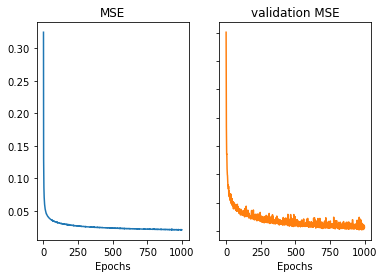

In [9]:
(model_4L,NNParameters) = GeneralizedNNCalibration4L(model_name[idx],num_params[idx],strikes,maturities, 42, plot_history=True)

Epoch 1/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.3337 - val_loss: 0.1606
Epoch 2/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.1343 - val_loss: 0.1192
Epoch 3/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.1056 - val_loss: 0.0976
Epoch 4/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0913 - val_loss: 0.0892
Epoch 5/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0824 - val_loss: 0.0858
Epoch 6/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0761 - val_loss: 0.0748
Epoch 7/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0715 - val_loss: 0.0711
Epoch 8/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0677 - val_loss: 0.0764
Epoch 9/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0647 - val_loss: 0.0653
Epoch 10/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.062

479/479 [==============================] - 1s 2ms/step - loss: 0.0330 - val_loss: 0.0355
Epoch 81/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0333 - val_loss: 0.0346
Epoch 82/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0330 - val_loss: 0.0345
Epoch 83/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0328 - val_loss: 0.0340
Epoch 84/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0326 - val_loss: 0.0409
Epoch 85/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0329 - val_loss: 0.0325
Epoch 86/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0323 - val_loss: 0.0392
Epoch 87/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0324 - val_loss: 0.0323
Epoch 88/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0324 - val_loss: 0.0340
Epoch 89/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0325 - v

479/479 [==============================] - 1s 2ms/step - loss: 0.0285 - val_loss: 0.0288
Epoch 160/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0286 - val_loss: 0.0288
Epoch 161/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0284 - val_loss: 0.0313
Epoch 162/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0283 - val_loss: 0.0281
Epoch 163/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0283 - val_loss: 0.0291
Epoch 164/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0283 - val_loss: 0.0292
Epoch 165/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0281 - val_loss: 0.0335
Epoch 166/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0281 - val_loss: 0.0297
Epoch 167/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0286 - val_loss: 0.0299
Epoch 168/1000
479/479 [==============================] - 1s 2ms/step - loss: 0

Epoch 238/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0265 - val_loss: 0.0293
Epoch 239/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0262 - val_loss: 0.0269
Epoch 240/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0260 - val_loss: 0.0262
Epoch 241/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0263 - val_loss: 0.0278
Epoch 242/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0264 - val_loss: 0.0261
Epoch 243/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0259 - val_loss: 0.0269
Epoch 244/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0260 - val_loss: 0.0298
Epoch 245/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0266 - val_loss: 0.0275
Epoch 246/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0259 - val_loss: 0.0343
Epoch 247/1000
479/479 [==============================] - 2s 3ms

Epoch 317/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0248 - val_loss: 0.0278
Epoch 318/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0249 - val_loss: 0.0257
Epoch 319/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0245 - val_loss: 0.0266
Epoch 320/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0251 - val_loss: 0.0258
Epoch 321/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0248 - val_loss: 0.0273
Epoch 322/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0247 - val_loss: 0.0240
Epoch 323/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0247 - val_loss: 0.0281
Epoch 324/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0247 - val_loss: 0.0316
Epoch 325/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0250 - val_loss: 0.0281
Epoch 326/1000
479/479 [==============================] - 1s 3ms

Epoch 396/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0238 - val_loss: 0.0269
Epoch 397/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0241 - val_loss: 0.0243
Epoch 398/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0237 - val_loss: 0.0233
Epoch 399/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0237 - val_loss: 0.0248
Epoch 400/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0238 - val_loss: 0.0251
Epoch 401/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0240 - val_loss: 0.0262
Epoch 402/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0238 - val_loss: 0.0254
Epoch 403/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0237 - val_loss: 0.0249
Epoch 404/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0236 - val_loss: 0.0245
Epoch 405/1000
479/479 [==============================] - 1s 3ms

Epoch 475/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0228 - val_loss: 0.0254
Epoch 476/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0231 - val_loss: 0.0238
Epoch 477/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0230 - val_loss: 0.0262
Epoch 478/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0231 - val_loss: 0.0279
Epoch 479/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0229 - val_loss: 0.0240
Epoch 480/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0231 - val_loss: 0.0267
Epoch 481/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0229 - val_loss: 0.0234
Epoch 482/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0229 - val_loss: 0.0253
Epoch 483/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0228 - val_loss: 0.0246
Epoch 484/1000
479/479 [==============================] - 1s 3ms

Epoch 554/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0226 - val_loss: 0.0236
Epoch 555/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0224 - val_loss: 0.0249
Epoch 556/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0225 - val_loss: 0.0280
Epoch 557/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0227 - val_loss: 0.0248
Epoch 558/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0220 - val_loss: 0.0219
Epoch 559/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0223 - val_loss: 0.0227
Epoch 560/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0227 - val_loss: 0.0234
Epoch 561/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0221 - val_loss: 0.0255
Epoch 562/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0234 - val_loss: 0.0226
Epoch 563/1000
479/479 [==============================] - 1s 2ms

479/479 [==============================] - 1s 2ms/step - loss: 0.0217 - val_loss: 0.0252
Epoch 633/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0218 - val_loss: 0.0231
Epoch 634/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0216 - val_loss: 0.0262
Epoch 635/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0219 - val_loss: 0.0231
Epoch 636/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0216 - val_loss: 0.0229
Epoch 637/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0217 - val_loss: 0.0241
Epoch 638/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0219 - val_loss: 0.0247
Epoch 639/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0217 - val_loss: 0.0240
Epoch 640/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0220 - val_loss: 0.0225
Epoch 641/1000
479/479 [==============================] - 1s 2ms/step - loss: 0

Epoch 711/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0214 - val_loss: 0.0230
Epoch 712/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0212 - val_loss: 0.0232
Epoch 713/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0214 - val_loss: 0.0217
Epoch 714/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0213 - val_loss: 0.0239
Epoch 715/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0210 - val_loss: 0.0233
Epoch 716/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0213 - val_loss: 0.0221
Epoch 717/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0212 - val_loss: 0.0232
Epoch 718/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0213 - val_loss: 0.0265
Epoch 719/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0213 - val_loss: 0.0217
Epoch 720/1000
479/479 [==============================] - 1s 2ms

Epoch 790/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0210 - val_loss: 0.0240
Epoch 791/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0208 - val_loss: 0.0219
Epoch 792/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0210 - val_loss: 0.0219
Epoch 793/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0205 - val_loss: 0.0228
Epoch 794/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0209 - val_loss: 0.0219
Epoch 795/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0207 - val_loss: 0.0223
Epoch 796/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0212 - val_loss: 0.0207
Epoch 797/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0205 - val_loss: 0.0229
Epoch 798/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0209 - val_loss: 0.0221
Epoch 799/1000
479/479 [==============================] - 1s 2ms

479/479 [==============================] - 1s 2ms/step - loss: 0.0204 - val_loss: 0.0233
Epoch 869/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0206 - val_loss: 0.0229
Epoch 870/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0204 - val_loss: 0.0224
Epoch 871/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0205 - val_loss: 0.0216
Epoch 872/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0205 - val_loss: 0.0226
Epoch 873/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0205 - val_loss: 0.0219
Epoch 874/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0203 - val_loss: 0.0223
Epoch 875/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0204 - val_loss: 0.0260
Epoch 876/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0204 - val_loss: 0.0222
Epoch 877/1000
479/479 [==============================] - 1s 2ms/step - loss: 0

Epoch 947/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0201 - val_loss: 0.0200
Epoch 948/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0200 - val_loss: 0.0201
Epoch 949/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0201 - val_loss: 0.0249
Epoch 950/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0202 - val_loss: 0.0219
Epoch 951/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0202 - val_loss: 0.0246
Epoch 952/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0204 - val_loss: 0.0214
Epoch 953/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0200 - val_loss: 0.0197
Epoch 954/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0199 - val_loss: 0.0202
Epoch 955/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0201 - val_loss: 0.0230
Epoch 956/1000
479/479 [==============================] - 1s 2ms

<Figure size 1008x288 with 0 Axes>

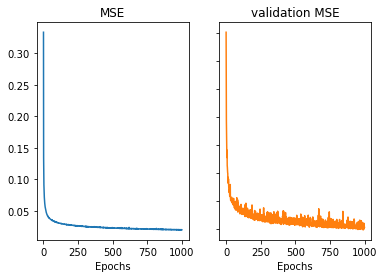

In [10]:
(model_5L,NNParameters) = GeneralizedNNCalibration5L(model_name[idx],num_params[idx],strikes,maturities, 42, plot_history=True)

Epoch 1/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.3216 - val_loss: 0.1635
Epoch 2/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.1327 - val_loss: 0.1115
Epoch 3/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0988 - val_loss: 0.0942
Epoch 4/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0846 - val_loss: 0.0820
Epoch 5/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0769 - val_loss: 0.0759
Epoch 6/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0707 - val_loss: 0.0700
Epoch 7/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0661 - val_loss: 0.0678
Epoch 8/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0628 - val_loss: 0.0665
Epoch 9/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0598 - val_loss: 0.0610
Epoch 10/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.057

479/479 [==============================] - 1s 2ms/step - loss: 0.0331 - val_loss: 0.0341
Epoch 81/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0331 - val_loss: 0.0332
Epoch 82/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0326 - val_loss: 0.0433
Epoch 83/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0328 - val_loss: 0.0356
Epoch 84/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0325 - val_loss: 0.0328
Epoch 85/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0328 - val_loss: 0.0376
Epoch 86/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0325 - val_loss: 0.0360
Epoch 87/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0322 - val_loss: 0.0328
Epoch 88/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0325 - val_loss: 0.0377
Epoch 89/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0325 - v

479/479 [==============================] - 1s 2ms/step - loss: 0.0284 - val_loss: 0.0309
Epoch 160/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0286 - val_loss: 0.0311
Epoch 161/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0286 - val_loss: 0.0307
Epoch 162/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0287 - val_loss: 0.0277
Epoch 163/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0280 - val_loss: 0.0291
Epoch 164/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0285 - val_loss: 0.0293
Epoch 165/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0281 - val_loss: 0.0325
Epoch 166/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0285 - val_loss: 0.0285
Epoch 167/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0282 - val_loss: 0.0349
Epoch 168/1000
479/479 [==============================] - 1s 2ms/step - loss: 0

Epoch 238/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0259 - val_loss: 0.0337
Epoch 239/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0263 - val_loss: 0.0278
Epoch 240/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0258 - val_loss: 0.0259
Epoch 241/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0262 - val_loss: 0.0287
Epoch 242/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0262 - val_loss: 0.0323
Epoch 243/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0260 - val_loss: 0.0294
Epoch 244/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0262 - val_loss: 0.0314
Epoch 245/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0258 - val_loss: 0.0326
Epoch 246/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0264 - val_loss: 0.0301
Epoch 247/1000
479/479 [==============================] - 1s 2ms

Epoch 317/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0247 - val_loss: 0.0244
Epoch 318/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0246 - val_loss: 0.0265
Epoch 319/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0247 - val_loss: 0.0267
Epoch 320/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0248 - val_loss: 0.0264
Epoch 321/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0248 - val_loss: 0.0269
Epoch 322/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0247 - val_loss: 0.0260
Epoch 323/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0251 - val_loss: 0.0252
Epoch 324/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0247 - val_loss: 0.0234
Epoch 325/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0256 - val_loss: 0.0256
Epoch 326/1000
479/479 [==============================] - 1s 2ms

Epoch 396/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0241 - val_loss: 0.0276
Epoch 397/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0238 - val_loss: 0.0273
Epoch 398/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0239 - val_loss: 0.0260
Epoch 399/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0238 - val_loss: 0.0259
Epoch 400/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0238 - val_loss: 0.0290
Epoch 401/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0236 - val_loss: 0.0269
Epoch 402/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0239 - val_loss: 0.0263
Epoch 403/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0244 - val_loss: 0.0255
Epoch 404/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0241 - val_loss: 0.0260
Epoch 405/1000
479/479 [==============================] - 1s 3ms

Epoch 475/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0232 - val_loss: 0.0332
Epoch 476/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0235 - val_loss: 0.0273
Epoch 477/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0231 - val_loss: 0.0237
Epoch 478/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0234 - val_loss: 0.0253
Epoch 479/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0233 - val_loss: 0.0243
Epoch 480/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0233 - val_loss: 0.0243
Epoch 481/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0232 - val_loss: 0.0265
Epoch 482/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0232 - val_loss: 0.0257
Epoch 483/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0231 - val_loss: 0.0236
Epoch 484/1000
479/479 [==============================] - 2s 3ms

479/479 [==============================] - 1s 2ms/step - loss: 0.0226 - val_loss: 0.0232
Epoch 554/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0227 - val_loss: 0.0233
Epoch 555/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0225 - val_loss: 0.0256
Epoch 556/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0226 - val_loss: 0.0240
Epoch 557/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0225 - val_loss: 0.0320
Epoch 558/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0238 - val_loss: 0.0223
Epoch 559/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0222 - val_loss: 0.0236
Epoch 560/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0225 - val_loss: 0.0226
Epoch 561/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0225 - val_loss: 0.0256
Epoch 562/1000
479/479 [==============================] - 2s 3ms/step - loss: 0

Epoch 632/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0221 - val_loss: 0.0226
Epoch 633/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0220 - val_loss: 0.0256
Epoch 634/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0222 - val_loss: 0.0246
Epoch 635/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0220 - val_loss: 0.0241
Epoch 636/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0221 - val_loss: 0.0273
Epoch 637/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0220 - val_loss: 0.0272
Epoch 638/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0223 - val_loss: 0.0255
Epoch 639/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0224 - val_loss: 0.0265
Epoch 640/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0220 - val_loss: 0.0219
Epoch 641/1000
479/479 [==============================] - 1s 3ms

Epoch 711/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0217 - val_loss: 0.0246
Epoch 712/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0217 - val_loss: 0.0224
Epoch 713/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0216 - val_loss: 0.0208
Epoch 714/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0219 - val_loss: 0.0232
Epoch 715/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0215 - val_loss: 0.0235
Epoch 716/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0217 - val_loss: 0.0235
Epoch 717/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0218 - val_loss: 0.0283
Epoch 718/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0217 - val_loss: 0.0220
Epoch 719/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0217 - val_loss: 0.0248
Epoch 720/1000
479/479 [==============================] - 1s 3ms

Epoch 790/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0213 - val_loss: 0.0235
Epoch 791/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0216 - val_loss: 0.0228
Epoch 792/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0213 - val_loss: 0.0259
Epoch 793/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0211 - val_loss: 0.0283
Epoch 794/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0213 - val_loss: 0.0248
Epoch 795/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0212 - val_loss: 0.0225
Epoch 796/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0214 - val_loss: 0.0256
Epoch 797/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0213 - val_loss: 0.0210
Epoch 798/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0220 - val_loss: 0.0237
Epoch 799/1000
479/479 [==============================] - 1s 2ms

<Figure size 1008x288 with 0 Axes>

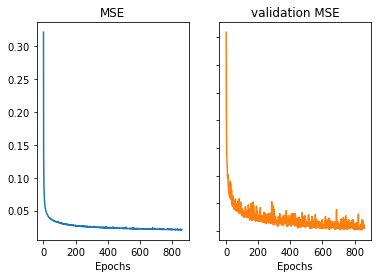

In [11]:
(model_6L,NNParameters) = GeneralizedNNCalibration6L(model_name[idx],num_params[idx],strikes,maturities, 42, plot_history=True)

In [12]:
f = gzip.GzipFile('Dataset/' + model_name[idx] + 'TrainSet.txt.gz', "r")
dat = np.load(f)
f.close()
xx = dat[:, :num_params[idx]]
yy = dat[:, num_params[idx]:]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(yy, xx, test_size=0.15, random_state=42)

ub = np.max(xx,axis=0)
lb = np.min(xx,axis=0)

scale2=StandardScaler()

scale2.fit(X_train)

[x_train_transform, x_test_transform] = [scale2.transform (X_train), scale2.transform (X_test)]

y_train_transform = np.array([myscale(y,ub,lb) for y in y_train])
y_test_transform = np.array([myscale(y,ub,lb) for y in y_test])


model_3L.evaluate(y_test_transform,x_test_transform)

375/375 [==============================] - 1s 3ms/step - loss: 0.0269


0.026922352612018585

In [13]:
model_4L.evaluate(y_test_transform,x_test_transform)

375/375 [==============================] - 1s 3ms/step - loss: 0.0224


0.022369278594851494

In [14]:
model_5L.evaluate(y_test_transform,x_test_transform)

375/375 [==============================] - 1s 3ms/step - loss: 0.0211


0.021067438647150993

In [15]:
model_6L.evaluate(y_test_transform,x_test_transform)

375/375 [==============================] - 1s 3ms/step - loss: 0.0206


0.02062016725540161

Epoch 1/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.3594 - val_loss: 0.1699
Epoch 2/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.1292 - val_loss: 0.1023
Epoch 3/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0915 - val_loss: 0.0819
Epoch 4/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0771 - val_loss: 0.0722
Epoch 5/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0690 - val_loss: 0.0667
Epoch 6/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0638 - val_loss: 0.0635
Epoch 7/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0598 - val_loss: 0.0585
Epoch 8/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0569 - val_loss: 0.0573
Epoch 9/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0543 - val_loss: 0.0559
Epoch 10/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.052

479/479 [==============================] - 1s 2ms/step - loss: 0.0309 - val_loss: 0.0320
Epoch 81/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0308 - val_loss: 0.0306
Epoch 82/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0307 - val_loss: 0.0312
Epoch 83/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0305 - val_loss: 0.0321
Epoch 84/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0306 - val_loss: 0.0328
Epoch 85/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0303 - val_loss: 0.0313
Epoch 86/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0303 - val_loss: 0.0306
Epoch 87/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0303 - val_loss: 0.0323
Epoch 88/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0300 - val_loss: 0.0338
Epoch 89/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0302 - v

479/479 [==============================] - 1s 2ms/step - loss: 0.0273 - val_loss: 0.0278
Epoch 160/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0266 - val_loss: 0.0280
Epoch 161/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0266 - val_loss: 0.0278
Epoch 162/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0266 - val_loss: 0.0272
Epoch 163/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0266 - val_loss: 0.0280
Epoch 164/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0266 - val_loss: 0.0271
Epoch 165/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0267 - val_loss: 0.0269
Epoch 166/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0265 - val_loss: 0.0276
Epoch 167/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0266 - val_loss: 0.0275
Epoch 168/1000
479/479 [==============================] - 1s 2ms/step - loss: 0

Epoch 238/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0250 - val_loss: 0.0268
Epoch 239/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0250 - val_loss: 0.0264
Epoch 240/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0249 - val_loss: 0.0253
Epoch 241/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0251 - val_loss: 0.0280
Epoch 242/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0250 - val_loss: 0.0279
Epoch 243/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0249 - val_loss: 0.0263
Epoch 244/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0251 - val_loss: 0.0273
Epoch 245/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0248 - val_loss: 0.0262
Epoch 246/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0250 - val_loss: 0.0278
Epoch 247/1000
479/479 [==============================] - 1s 3ms

479/479 [==============================] - 1s 2ms/step - loss: 0.0238 - val_loss: 0.0267
Epoch 317/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0239 - val_loss: 0.0249
Epoch 318/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0238 - val_loss: 0.0266
Epoch 319/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0237 - val_loss: 0.0246
Epoch 320/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0238 - val_loss: 0.0277
Epoch 321/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0238 - val_loss: 0.0248
Epoch 322/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0238 - val_loss: 0.0244
Epoch 323/1000
479/479 [==============================] - ETA: 0s - loss: 0.023 - 1s 3ms/step - loss: 0.0237 - val_loss: 0.0251
Epoch 324/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0237 - val_loss: 0.0268
Epoch 325/1000
479/479 [==============================]

479/479 [==============================] - 1s 3ms/step - loss: 0.0230 - val_loss: 0.0236
Epoch 395/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0230 - val_loss: 0.0275
Epoch 396/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0230 - val_loss: 0.0237
Epoch 397/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0229 - val_loss: 0.0231
Epoch 398/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0228 - val_loss: 0.0236
Epoch 399/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0231 - val_loss: 0.0235
Epoch 400/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0230 - val_loss: 0.0250
Epoch 401/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0230 - val_loss: 0.0235
Epoch 402/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0229 - val_loss: 0.0231
Epoch 403/1000
479/479 [==============================] - 1s 2ms/step - loss: 0

479/479 [==============================] - 1s 2ms/step - loss: 0.0223 - val_loss: 0.0238
Epoch 473/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0224 - val_loss: 0.0252
Epoch 474/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0224 - val_loss: 0.0227
Epoch 475/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0223 - val_loss: 0.0230s - loss: 0.02
Epoch 476/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0223 - val_loss: 0.0225
Epoch 477/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0223 - val_loss: 0.0233
Epoch 478/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0223 - val_loss: 0.0238
Epoch 479/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0224 - val_loss: 0.0243
Epoch 480/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0223 - val_loss: 0.0266
Epoch 481/1000
479/479 [==============================] - 1s 3ms/

Epoch 551/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0218 - val_loss: 0.0225
Epoch 552/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0218 - val_loss: 0.0222
Epoch 553/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0219 - val_loss: 0.0233
Epoch 554/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0219 - val_loss: 0.0232
Epoch 555/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0217 - val_loss: 0.0252
Epoch 556/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0216 - val_loss: 0.0220
Epoch 557/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0219 - val_loss: 0.0230
Epoch 558/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0217 - val_loss: 0.0230
Epoch 559/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0219 - val_loss: 0.0224
Epoch 560/1000
479/479 [==============================] - 1s 2ms

479/479 [==============================] - 1s 3ms/step - loss: 0.0213 - val_loss: 0.0238
Epoch 630/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0215 - val_loss: 0.0221
Epoch 631/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0215 - val_loss: 0.0237
Epoch 632/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0214 - val_loss: 0.0235
Epoch 633/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0214 - val_loss: 0.0226
Epoch 634/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0214 - val_loss: 0.0229
Epoch 635/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0214 - val_loss: 0.0255
Epoch 636/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0214 - val_loss: 0.0240
Epoch 637/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0217 - val_loss: 0.0227
Epoch 638/1000
479/479 [==============================] - 1s 3ms/step - loss: 0

Epoch 708/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0210 - val_loss: 0.0223
Epoch 709/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0211 - val_loss: 0.0222
Epoch 710/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0211 - val_loss: 0.0223
Epoch 711/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0210 - val_loss: 0.0213
Epoch 712/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0210 - val_loss: 0.0211
Epoch 713/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0211 - val_loss: 0.0235
Epoch 714/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0209 - val_loss: 0.0214
Epoch 715/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0211 - val_loss: 0.0222
Epoch 716/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0208 - val_loss: 0.0236
Epoch 717/1000
479/479 [==============================] - 1s 3ms

479/479 [==============================] - 1s 3ms/step - loss: 0.0206 - val_loss: 0.0227
Epoch 787/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0206 - val_loss: 0.0207
Epoch 788/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0208 - val_loss: 0.0228
Epoch 789/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0207 - val_loss: 0.0210
Epoch 790/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0206 - val_loss: 0.0222
Epoch 791/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0208 - val_loss: 0.0235
Epoch 792/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0209 - val_loss: 0.0219
Epoch 793/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0206 - val_loss: 0.0220
Epoch 794/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0207 - val_loss: 0.0228
Epoch 795/1000
479/479 [==============================] - 1s 2ms/step - loss: 0

Epoch 865/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0204 - val_loss: 0.0212
Epoch 866/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0204 - val_loss: 0.0232
Epoch 867/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0204 - val_loss: 0.0236
Epoch 868/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0205 - val_loss: 0.0213
Epoch 869/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0204 - val_loss: 0.0209
Epoch 870/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0203 - val_loss: 0.0212
Epoch 871/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0206 - val_loss: 0.0227
Epoch 872/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0203 - val_loss: 0.0214
Epoch 873/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0204 - val_loss: 0.0211
Epoch 874/1000
479/479 [==============================] - 1s 3ms

Epoch 944/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0201 - val_loss: 0.0214
Epoch 945/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0203 - val_loss: 0.0217
Epoch 946/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0201 - val_loss: 0.0218
Epoch 947/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0202 - val_loss: 0.0226
Epoch 948/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0203 - val_loss: 0.0207
Epoch 949/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0202 - val_loss: 0.0209
Epoch 950/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0201 - val_loss: 0.0221
Epoch 951/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0201 - val_loss: 0.0219
Epoch 952/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0203 - val_loss: 0.0229
Epoch 953/1000
479/479 [==============================] - 1s 2ms

<Figure size 1008x288 with 0 Axes>

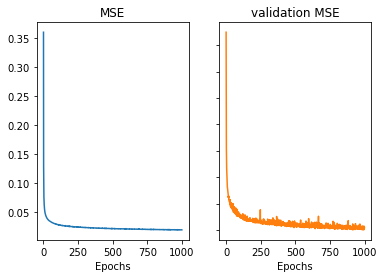

In [16]:
idx = 6

(model_3L,NNParameters) = GeneralizedNNCalibration3L(model_name[idx],num_params[idx],strikes,maturities, 18, plot_history=True)

Epoch 1/1000
479/479 [==============================] - 2s 4ms/step - loss: 0.3426 - val_loss: 0.1501
Epoch 2/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.1191 - val_loss: 0.0995
Epoch 3/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0899 - val_loss: 0.0839
Epoch 4/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0777 - val_loss: 0.0797
Epoch 5/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0708 - val_loss: 0.0704
Epoch 6/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0659 - val_loss: 0.0669
Epoch 7/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0620 - val_loss: 0.0608
Epoch 8/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0595 - val_loss: 0.0589
Epoch 9/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0569 - val_loss: 0.0566
Epoch 10/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.055

479/479 [==============================] - 1s 2ms/step - loss: 0.0312 - val_loss: 0.0317
Epoch 81/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0311 - val_loss: 0.0324
Epoch 82/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0311 - val_loss: 0.0343
Epoch 83/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0309 - val_loss: 0.0357
Epoch 84/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0310 - val_loss: 0.0322
Epoch 85/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0309 - val_loss: 0.0338
Epoch 86/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0308 - val_loss: 0.0309
Epoch 87/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0304 - val_loss: 0.0324
Epoch 88/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0306 - val_loss: 0.0331
Epoch 89/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0303 - v

479/479 [==============================] - 1s 2ms/step - loss: 0.0264 - val_loss: 0.0288
Epoch 160/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0267 - val_loss: 0.0282
Epoch 161/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0266 - val_loss: 0.0264
Epoch 162/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0266 - val_loss: 0.0301
Epoch 163/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0264 - val_loss: 0.0273
Epoch 164/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0263 - val_loss: 0.0272
Epoch 165/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0266 - val_loss: 0.0278
Epoch 166/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0264 - val_loss: 0.0279
Epoch 167/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0263 - val_loss: 0.0294
Epoch 168/1000
479/479 [==============================] - 1s 2ms/step - loss: 0

Epoch 238/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0245 - val_loss: 0.0248
Epoch 239/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0246 - val_loss: 0.0252
Epoch 240/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0245 - val_loss: 0.0260
Epoch 241/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0246 - val_loss: 0.0255
Epoch 242/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0247 - val_loss: 0.0258
Epoch 243/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0249 - val_loss: 0.0259
Epoch 244/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0245 - val_loss: 0.0257
Epoch 245/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0245 - val_loss: 0.0265
Epoch 246/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0242 - val_loss: 0.0275
Epoch 247/1000
479/479 [==============================] - 1s 3ms

Epoch 317/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0233 - val_loss: 0.0251
Epoch 318/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0231 - val_loss: 0.0244
Epoch 319/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0232 - val_loss: 0.0239
Epoch 320/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0234 - val_loss: 0.0232
Epoch 321/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0231 - val_loss: 0.0270
Epoch 322/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0232 - val_loss: 0.0247
Epoch 323/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0231 - val_loss: 0.0228
Epoch 324/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0229 - val_loss: 0.0281
Epoch 325/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0232 - val_loss: 0.0277
Epoch 326/1000
479/479 [==============================] - 1s 3ms

Epoch 396/1000
479/479 [==============================] - 2s 4ms/step - loss: 0.0220 - val_loss: 0.0218
Epoch 397/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0222 - val_loss: 0.0241
Epoch 398/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0220 - val_loss: 0.0228
Epoch 399/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0218 - val_loss: 0.0219
Epoch 400/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0219 - val_loss: 0.0218
Epoch 401/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0219 - val_loss: 0.0254
Epoch 402/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0219 - val_loss: 0.0259
Epoch 403/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0220 - val_loss: 0.0213
Epoch 404/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0219 - val_loss: 0.0260
Epoch 405/1000
479/479 [==============================] - 1s 3ms

Epoch 475/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0211 - val_loss: 0.0221
Epoch 476/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0211 - val_loss: 0.0229
Epoch 477/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0212 - val_loss: 0.0220
Epoch 478/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0211 - val_loss: 0.0245
Epoch 479/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0212 - val_loss: 0.0229
Epoch 480/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0211 - val_loss: 0.0217
Epoch 481/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0211 - val_loss: 0.0238
Epoch 482/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0211 - val_loss: 0.0238
Epoch 483/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0213 - val_loss: 0.0246
Epoch 484/1000
479/479 [==============================] - 1s 2ms

Epoch 554/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0203 - val_loss: 0.0201
Epoch 555/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0206 - val_loss: 0.0235
Epoch 556/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0206 - val_loss: 0.0208
Epoch 557/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0206 - val_loss: 0.0214
Epoch 558/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0202 - val_loss: 0.0233
Epoch 559/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0207 - val_loss: 0.0218
Epoch 560/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0206 - val_loss: 0.0251
Epoch 561/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0203 - val_loss: 0.0234
Epoch 562/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0205 - val_loss: 0.0236
Epoch 563/1000
479/479 [==============================] - 1s 3ms

Epoch 633/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0200 - val_loss: 0.0210
Epoch 634/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0201 - val_loss: 0.0239
Epoch 635/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0198 - val_loss: 0.0236
Epoch 636/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0198 - val_loss: 0.0210
Epoch 637/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0199 - val_loss: 0.0229
Epoch 638/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0199 - val_loss: 0.0197
Epoch 639/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0201 - val_loss: 0.0218
Epoch 640/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0200 - val_loss: 0.0240
Epoch 641/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0200 - val_loss: 0.0254
Epoch 642/1000
479/479 [==============================] - 1s 3ms

Epoch 712/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0195 - val_loss: 0.0233
Epoch 713/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0194 - val_loss: 0.0220
Epoch 714/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0195 - val_loss: 0.0235
Epoch 715/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0197 - val_loss: 0.0233
Epoch 716/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0196 - val_loss: 0.0215
Epoch 717/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0195 - val_loss: 0.0278
Epoch 718/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0194 - val_loss: 0.0233
Epoch 719/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0195 - val_loss: 0.0205
Epoch 720/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0195 - val_loss: 0.0202
Epoch 721/1000
479/479 [==============================] - 1s 3ms

479/479 [==============================] - 1s 2ms/step - loss: 0.0190 - val_loss: 0.0196
Epoch 791/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0192 - val_loss: 0.0210
Epoch 792/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0192 - val_loss: 0.0226
Epoch 793/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0192 - val_loss: 0.0194
Epoch 794/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0192 - val_loss: 0.0198
Epoch 795/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0192 - val_loss: 0.0210
Epoch 796/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0193 - val_loss: 0.0223
Epoch 797/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0191 - val_loss: 0.0245
Epoch 798/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0193 - val_loss: 0.0204
Epoch 799/1000
479/479 [==============================] - 1s 3ms/step - loss: 0

Epoch 869/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0188 - val_loss: 0.0202
Epoch 870/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0186 - val_loss: 0.0253
Epoch 871/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0190 - val_loss: 0.0221
Epoch 872/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0189 - val_loss: 0.0197
Epoch 873/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0188 - val_loss: 0.0236
Epoch 874/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0190 - val_loss: 0.0220
Epoch 875/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0188 - val_loss: 0.0200
Epoch 876/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0189 - val_loss: 0.0255
Epoch 877/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0189 - val_loss: 0.0211
Epoch 878/1000
479/479 [==============================] - 1s 3ms

Epoch 948/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0186 - val_loss: 0.0214
Epoch 949/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0187 - val_loss: 0.0216
Epoch 950/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0186 - val_loss: 0.0198
Epoch 951/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0188 - val_loss: 0.0211
Epoch 952/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0186 - val_loss: 0.0199
Epoch 953/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0186 - val_loss: 0.0191
Epoch 954/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0185 - val_loss: 0.0210
Epoch 955/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0186 - val_loss: 0.0273
Epoch 956/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0185 - val_loss: 0.0196
Epoch 957/1000
479/479 [==============================] - 1s 2ms

<Figure size 1008x288 with 0 Axes>

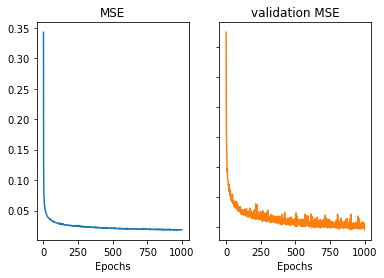

In [17]:
(model_4L,NNParameters) = GeneralizedNNCalibration4L(model_name[idx],num_params[idx],strikes,maturities, 18, plot_history=True)

Epoch 1/1000
479/479 [==============================] - 2s 4ms/step - loss: 0.3327 - val_loss: 0.1443
Epoch 2/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.1161 - val_loss: 0.1042
Epoch 3/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0888 - val_loss: 0.0862
Epoch 4/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0777 - val_loss: 0.0752
Epoch 5/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0700 - val_loss: 0.0697
Epoch 6/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0655 - val_loss: 0.0691
Epoch 7/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0612 - val_loss: 0.0597
Epoch 8/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0580 - val_loss: 0.0585
Epoch 9/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0556 - val_loss: 0.0626
Epoch 10/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.053

479/479 [==============================] - 1s 2ms/step - loss: 0.0300 - val_loss: 0.0310
Epoch 81/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0303 - val_loss: 0.0311
Epoch 82/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0296 - val_loss: 0.0375
Epoch 83/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0297 - val_loss: 0.0330
Epoch 84/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0295 - val_loss: 0.0315
Epoch 85/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0295 - val_loss: 0.0310
Epoch 86/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0294 - val_loss: 0.0289
Epoch 87/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0291 - val_loss: 0.0296
Epoch 88/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0297 - val_loss: 0.0323
Epoch 89/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0292 - v

Epoch 159/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0256 - val_loss: 0.0262
Epoch 160/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0253 - val_loss: 0.0288
Epoch 161/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0255 - val_loss: 0.0265
Epoch 162/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0256 - val_loss: 0.0302
Epoch 163/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0260 - val_loss: 0.0290
Epoch 164/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0251 - val_loss: 0.0272
Epoch 165/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0254 - val_loss: 0.0251
Epoch 166/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0253 - val_loss: 0.0258
Epoch 167/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0253 - val_loss: 0.0282
Epoch 168/1000
479/479 [==============================] - 1s 2ms

479/479 [==============================] - 1s 3ms/step - loss: 0.0236 - val_loss: 0.0264
Epoch 238/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0236 - val_loss: 0.0271
Epoch 239/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0236 - val_loss: 0.0267
Epoch 240/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0233 - val_loss: 0.0264
Epoch 241/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0233 - val_loss: 0.0264
Epoch 242/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0235 - val_loss: 0.0249
Epoch 243/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0234 - val_loss: 0.0244
Epoch 244/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0231 - val_loss: 0.0265
Epoch 245/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0239 - val_loss: 0.0291
Epoch 246/1000
479/479 [==============================] - 2s 3ms/step - loss: 0

479/479 [==============================] - 1s 3ms/step - loss: 0.0224 - val_loss: 0.0233
Epoch 316/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0220 - val_loss: 0.0236
Epoch 317/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0223 - val_loss: 0.0230
Epoch 318/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0222 - val_loss: 0.0242
Epoch 319/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0224 - val_loss: 0.0238
Epoch 320/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0223 - val_loss: 0.0229
Epoch 321/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0222 - val_loss: 0.0251
Epoch 322/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0219 - val_loss: 0.0233
Epoch 323/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0223 - val_loss: 0.0226
Epoch 324/1000
479/479 [==============================] - 1s 3ms/step - loss: 0

479/479 [==============================] - 1s 2ms/step - loss: 0.0213 - val_loss: 0.0254
Epoch 394/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0213 - val_loss: 0.0221
Epoch 395/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0212 - val_loss: 0.0235
Epoch 396/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0211 - val_loss: 0.0222
Epoch 397/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0211 - val_loss: 0.0240
Epoch 398/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0215 - val_loss: 0.0219
Epoch 399/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0209 - val_loss: 0.0259
Epoch 400/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0214 - val_loss: 0.0225
Epoch 401/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0212 - val_loss: 0.0230
Epoch 402/1000
479/479 [==============================] - 1s 3ms/step - loss: 0

Epoch 472/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0206 - val_loss: 0.0220
Epoch 473/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0203 - val_loss: 0.0245
Epoch 474/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0204 - val_loss: 0.0212
Epoch 475/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0205 - val_loss: 0.0220
Epoch 476/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0205 - val_loss: 0.0259
Epoch 477/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0206 - val_loss: 0.0237
Epoch 478/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0203 - val_loss: 0.0207
Epoch 479/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0204 - val_loss: 0.0226
Epoch 480/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0206 - val_loss: 0.0201
Epoch 481/1000
479/479 [==============================] - 1s 3ms

Epoch 551/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0198 - val_loss: 0.0230
Epoch 552/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0198 - val_loss: 0.0223
Epoch 553/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0198 - val_loss: 0.0199
Epoch 554/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0196 - val_loss: 0.0201
Epoch 555/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0198 - val_loss: 0.0224
Epoch 556/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0201 - val_loss: 0.0218
Epoch 557/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0200 - val_loss: 0.0204
Epoch 558/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0196 - val_loss: 0.0207
Epoch 559/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0199 - val_loss: 0.0218
Epoch 560/1000
479/479 [==============================] - 1s 3ms

479/479 [==============================] - 1s 3ms/step - loss: 0.0194 - val_loss: 0.0194
Epoch 630/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0194 - val_loss: 0.0206
Epoch 631/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0190 - val_loss: 0.0214
Epoch 632/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0194 - val_loss: 0.0264
Epoch 633/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0192 - val_loss: 0.0203
Epoch 634/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0191 - val_loss: 0.0231
Epoch 635/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0193 - val_loss: 0.0206
Epoch 636/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0192 - val_loss: 0.0199
Epoch 637/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0192 - val_loss: 0.0225
Epoch 638/1000
479/479 [==============================] - 1s 3ms/step - loss: 0

Epoch 708/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0188 - val_loss: 0.0210
Epoch 709/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0189 - val_loss: 0.0194
Epoch 710/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0190 - val_loss: 0.0200
Epoch 711/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0189 - val_loss: 0.0223
Epoch 712/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0188 - val_loss: 0.0236
Epoch 713/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0187 - val_loss: 0.0208
Epoch 714/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0188 - val_loss: 0.0207
Epoch 715/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0187 - val_loss: 0.0186
Epoch 716/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0188 - val_loss: 0.0201
Epoch 717/1000
479/479 [==============================] - 1s 3ms

Epoch 787/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0186 - val_loss: 0.0188
Epoch 788/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0183 - val_loss: 0.0208
Epoch 789/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0184 - val_loss: 0.0191
Epoch 790/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0186 - val_loss: 0.0229
Epoch 791/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0187 - val_loss: 0.0191
Epoch 792/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0184 - val_loss: 0.0220
Epoch 793/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0185 - val_loss: 0.0194
Epoch 794/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0183 - val_loss: 0.0198
Epoch 795/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0184 - val_loss: 0.0197
Epoch 796/1000
479/479 [==============================] - 1s 3ms

Epoch 866/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0180 - val_loss: 0.0203
Epoch 867/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0181 - val_loss: 0.0181
Epoch 868/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0181 - val_loss: 0.0179
Epoch 869/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0182 - val_loss: 0.0185
Epoch 870/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0182 - val_loss: 0.0213
Epoch 871/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0182 - val_loss: 0.0199
Epoch 872/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0183 - val_loss: 0.0216
Epoch 873/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0181 - val_loss: 0.0190
Epoch 874/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0181 - val_loss: 0.0191
Epoch 875/1000
479/479 [==============================] - 2s 3ms

Epoch 945/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0179 - val_loss: 0.0187
Epoch 946/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0180 - val_loss: 0.0181
Epoch 947/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0181 - val_loss: 0.0192
Epoch 948/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0180 - val_loss: 0.0197
Epoch 949/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0178 - val_loss: 0.0197
Epoch 950/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0179 - val_loss: 0.0200
Epoch 951/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0180 - val_loss: 0.0192
Epoch 952/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0177 - val_loss: 0.0193
Epoch 953/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0181 - val_loss: 0.0199
Epoch 954/1000
479/479 [==============================] - 1s 3ms

<Figure size 1008x288 with 0 Axes>

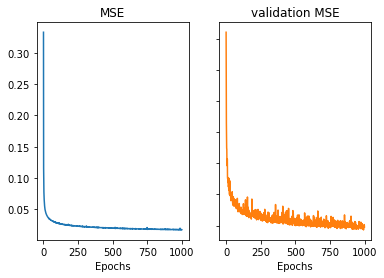

In [18]:
(model_5L,NNParameters) = GeneralizedNNCalibration5L(model_name[idx],num_params[idx],strikes,maturities, 18, plot_history=True)

Epoch 1/1000
479/479 [==============================] - 2s 4ms/step - loss: 0.3239 - val_loss: 0.1475
Epoch 2/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.1190 - val_loss: 0.1022
Epoch 3/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0890 - val_loss: 0.0843
Epoch 4/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0768 - val_loss: 0.0723
Epoch 5/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0692 - val_loss: 0.0714
Epoch 6/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0649 - val_loss: 0.0664
Epoch 7/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0611 - val_loss: 0.0601
Epoch 8/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0581 - val_loss: 0.0608
Epoch 9/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0561 - val_loss: 0.0573
Epoch 10/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.054

479/479 [==============================] - 2s 3ms/step - loss: 0.0312 - val_loss: 0.0331
Epoch 81/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0308 - val_loss: 0.0331
Epoch 82/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0307 - val_loss: 0.0365
Epoch 83/1000
479/479 [==============================] - 2s 4ms/step - loss: 0.0309 - val_loss: 0.0343
Epoch 84/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0306 - val_loss: 0.0319
Epoch 85/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0304 - val_loss: 0.0304
Epoch 86/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0306 - val_loss: 0.0383
Epoch 87/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0303 - val_loss: 0.0329
Epoch 88/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0305 - val_loss: 0.0330
Epoch 89/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0302 - v

479/479 [==============================] - 2s 3ms/step - loss: 0.0262 - val_loss: 0.0300
Epoch 160/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0263 - val_loss: 0.0277
Epoch 161/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0262 - val_loss: 0.0289
Epoch 162/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0263 - val_loss: 0.0298
Epoch 163/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0260 - val_loss: 0.0270
Epoch 164/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0262 - val_loss: 0.0342
Epoch 165/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0262 - val_loss: 0.0283
Epoch 166/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0264 - val_loss: 0.0292
Epoch 167/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0258 - val_loss: 0.0308
Epoch 168/1000
479/479 [==============================] - 2s 3ms/step - loss: 0

479/479 [==============================] - 2s 3ms/step - loss: 0.0241 - val_loss: 0.0262
Epoch 238/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0240 - val_loss: 0.0273
Epoch 239/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0244 - val_loss: 0.0253
Epoch 240/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0235 - val_loss: 0.0238
Epoch 241/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0240 - val_loss: 0.0264
Epoch 242/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0240 - val_loss: 0.0255
Epoch 243/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0241 - val_loss: 0.0292
Epoch 244/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0240 - val_loss: 0.0252
Epoch 245/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0237 - val_loss: 0.0251 loss: 0
Epoch 246/1000
479/479 [==============================] - 1s 3ms/step -

Epoch 316/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0227 - val_loss: 0.0280
Epoch 317/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0229 - val_loss: 0.0246
Epoch 318/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0228 - val_loss: 0.0233
Epoch 319/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0226 - val_loss: 0.0243
Epoch 320/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0227 - val_loss: 0.0244
Epoch 321/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0228 - val_loss: 0.0253
Epoch 322/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0227 - val_loss: 0.0261
Epoch 323/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0229 - val_loss: 0.0227
Epoch 324/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0224 - val_loss: 0.0248
Epoch 325/1000
479/479 [==============================] - 2s 3ms

Epoch 395/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0217 - val_loss: 0.0239
Epoch 396/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0217 - val_loss: 0.0247
Epoch 397/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0223 - val_loss: 0.0222
Epoch 398/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0216 - val_loss: 0.0243
Epoch 399/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0219 - val_loss: 0.0347
Epoch 400/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0218 - val_loss: 0.0225
Epoch 401/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0213 - val_loss: 0.0278
Epoch 402/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0220 - val_loss: 0.0258
Epoch 403/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0216 - val_loss: 0.0240
Epoch 404/1000
479/479 [==============================] - 1s 3ms

Epoch 474/1000
479/479 [==============================] - 2s 4ms/step - loss: 0.0207 - val_loss: 0.0211
Epoch 475/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0209 - val_loss: 0.0216
Epoch 476/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0212 - val_loss: 0.0231
Epoch 477/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0208 - val_loss: 0.0287
Epoch 478/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0209 - val_loss: 0.0273
Epoch 479/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0212 - val_loss: 0.0278
Epoch 480/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0207 - val_loss: 0.0265
Epoch 481/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0208 - val_loss: 0.0207
Epoch 482/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0209 - val_loss: 0.0218
Epoch 483/1000
479/479 [==============================] - 2s 3ms

479/479 [==============================] - 1s 3ms/step - loss: 0.0206 - val_loss: 0.0218
Epoch 553/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0204 - val_loss: 0.0221
Epoch 554/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0202 - val_loss: 0.0221
Epoch 555/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0203 - val_loss: 0.0245
Epoch 556/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0204 - val_loss: 0.0221
Epoch 557/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0203 - val_loss: 0.0235
Epoch 558/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0206 - val_loss: 0.0201
Epoch 559/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0205 - val_loss: 0.0214
Epoch 560/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0202 - val_loss: 0.0224
Epoch 561/1000
479/479 [==============================] - 2s 3ms/step - loss: 0

Epoch 631/1000
479/479 [==============================] - 1s 2ms/step - loss: 0.0200 - val_loss: 0.0250
Epoch 632/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0199 - val_loss: 0.0206
Epoch 633/1000
479/479 [==============================] - ETA: 0s - loss: 0.019 - 2s 3ms/step - loss: 0.0198 - val_loss: 0.0206
Epoch 634/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0195 - val_loss: 0.0206
Epoch 635/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0199 - val_loss: 0.0239
Epoch 636/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0197 - val_loss: 0.0253
Epoch 637/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0201 - val_loss: 0.0199
Epoch 638/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0197 - val_loss: 0.0233
Epoch 639/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0196 - val_loss: 0.0186
Epoch 640/1000
479/479 [================

479/479 [==============================] - 1s 3ms/step - loss: 0.0192 - val_loss: 0.0200
Epoch 710/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0192 - val_loss: 0.0232
Epoch 711/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0193 - val_loss: 0.0248
Epoch 712/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0194 - val_loss: 0.0207
Epoch 713/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0193 - val_loss: 0.0211
Epoch 714/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0196 - val_loss: 0.0193
Epoch 715/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0194 - val_loss: 0.0215
Epoch 716/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0197 - val_loss: 0.0257
Epoch 717/1000
479/479 [==============================] - 1s 3ms/step - loss: 0.0194 - val_loss: 0.0257
Epoch 718/1000
479/479 [==============================] - 1s 3ms/step - loss: 0

Epoch 788/1000
479/479 [==============================] - 2s 3ms/step - loss: 0.0192 - val_loss: 0.0198
Epoch 789/1000
479/479 [==============================] - 2s 4ms/step - loss: 0.0188 - val_loss: 0.0188


<Figure size 1008x288 with 0 Axes>

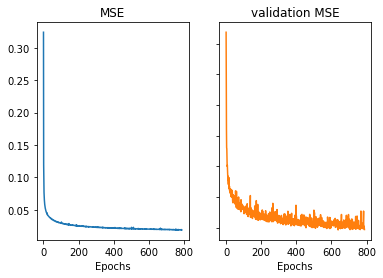

In [19]:
(model_6L,NNParameters) = GeneralizedNNCalibration6L(model_name[idx],num_params[idx],strikes,maturities, 18, plot_history=True)

In [20]:
f = gzip.GzipFile('Dataset/' + model_name[idx] + 'TrainSet.txt.gz', "r")
dat = np.load(f)
f.close()
xx = dat[:, :num_params[idx]]
yy = dat[:, num_params[idx]:]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(yy, xx, test_size=0.15, random_state=42)

ub = np.max(xx,axis=0)
lb = np.min(xx,axis=0)

scale2=StandardScaler()

scale2.fit(X_train)

[x_train_transform, x_test_transform] = [scale2.transform (X_train), scale2.transform (X_test)]

y_train_transform = np.array([myscale(y,ub,lb) for y in y_train])
y_test_transform = np.array([myscale(y,ub,lb) for y in y_test])


model_3L.evaluate(y_test_transform,x_test_transform)

375/375 [==============================] - 1s 3ms/step - loss: 0.0214


0.02135438844561577

In [21]:
model_4L.evaluate(y_test_transform,x_test_transform)

375/375 [==============================] - 1s 3ms/step - loss: 0.0179


0.017876453697681427

In [22]:
model_5L.evaluate(y_test_transform,x_test_transform)

375/375 [==============================] - 1s 3ms/step - loss: 0.0186


0.01857639104127884

In [23]:
model_6L.evaluate(y_test_transform,x_test_transform)

375/375 [==============================] - 1s 4ms/step - loss: 0.0181


0.018075183033943176